# **Temat**: **Bootstrapowa wersja testu t** 
## **Autorzy**: **Jakub Pietrzak** i **Dominik Strzałko**
## **Data**: 31.05.2021
##### **Opis zadania**: Implementacja powinna obejmować test dla jednej próby, dla dwóch prób niezależnych oraz dla dwóch prób zależnych. W każdej sytuacji oczekiwanym wejście jest zbiór danych w odpowiednim formacie, a wyjściem p-wartość oraz ostateczna decyzja. Dodatkowo powinien być rysowany odpowiedni rozkład statystyki testowej.

Link do collaba (Poprawne ładownie zakładek z wykresami): https://colab.research.google.com/drive/1BZG4qiM7GvT7un3lDWiiRImdNZmBabUp

### Pomocne linki:

1. https://towardsdatascience.com/master-your-hypothesis-test-a-tutorial-on-power-bootstrapping-sample-selection-and-outcome-273d6739d3e5

2. https://machinelearningmastery.com/calculate-bootstrap-confidence-intervals-machine-learning-results-python/

3. https://pl.wikipedia.org/wiki/Bootstrap_(statystyka)

4. https://pingouin-stats.org/_modules/pingouin/power.html#power_ttest

# **0.** Importowanie bibliotek i wspólne funckje

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import brenth
import pandas as pd
from google.colab import widgets

sns.set()

**Obliczanie wariancji** - średnia arytmetyczna kwadratów odchyleń od ich średniej arytmetycznej:

In [2]:
def get_variance(sample):
    n = len(sample)
    mean = sum(sample) / n
    deviations = [(x - mean) ** 2 for x in sample]
    return sum(deviations) / n

**Moc testu** - Moc testu (moc statystyczna) to prawdopodobieństwo niepopełnienia błędu drugiego rodzaju – nieodrzucenia hipotezy zerowej, gdy w rzeczywistości jest ona fałszywa. Im większe jest to prawdopodobieństwo, tym lepszy jest dany test jako narzędzie do różnicowania między hipotezą prawdziwą i fałszywą


Moc wacha się pomiędzy 0-1. Moc poniżej 0.8 jest zazwyczaj uważana za zbyt niską.

 
 Funkcja **get_min_sample_size** - Mówi nam ile potrzeba sampli, by uzyskać moc zbioru 1 (lub inną która podamy na wejściu)

In [3]:
def get_min_sample_size(d, power, alpha=0.05):

      def _eval_n(n, d, power, alpha):       
          dof = (n - 1) * 2
          nc = d * np.sqrt(n / 2)
          tcrit = stats.t.ppf(1 - alpha / 2, dof) #Percentyle
          x = (stats.nct.sf(tcrit, dof, nc) + stats.nct.cdf(-tcrit, dof, nc)) #sf - survival function (1- cdf) (cdf to dystrybuanta)
          return x - power

      return brenth(_eval_n, 2 + 1e-10, 1e+07, args=(d, power, alpha)) #Metoda to szukania miejsc zerowych w danym zakresie

**Bootstrap** – metoda szacowania (estymacji) wyników poprzez wielokrotne losowanie ze zwracaniem z próby. Polega ona na utworzeniu nowego rozkładu wyników, na podstawie posiadanych danych, poprzez wielokrotne losowanie wartości z posiadanej próby. Metoda ze zwracaniem polega na tym, że po wylosowaniu danej wartości, “wraca” ona z powrotem do zbioru.

In [4]:
def get_bootstrap_samples(min_sample_size, group):
    samples = []

    np.random.seed(seed=77)

    for _ in range(1000):
        sample_mean = np.random.choice(group, size=int(np.ceil(min_sample_size))).mean()
        samples.append(sample_mean)
    return np.array(samples)

Rysownie histgramów

In [5]:
def draw_histogram(group, title):
    bins = int(1 + 3.322* np.log(len(group)))
    fig = plt.figure(figsize=(12,8))
    plt.hist(group, bins=bins)
    plt.title(title)
    fig.show()

In [6]:
def draw_two_histograms(group1,group2, title):
    bins1 = int(1 + 3.322* np.log(len(group1)))
    bins2 = int(1 + 3.322* np.log(len(group2)))

    fig = plt.figure(figsize=(12,8))

    plt.hist(group1, bins=bins1, alpha=0.5)
    plt.hist(group2, bins=bins2, alpha=0.5)

    plt.title(title)
    fig.show()

Predykcja hipotezy

In [7]:
def predict_hypothesis(alpha, p_value):
    if p_value < alpha:
        print('odrzucamy hipotezę zerową')
    else:
        print('nie ma podstaw do odrzucenia hipotezy zerowej')


# **1.** Wersja dla dwóch prób niezależnych

### **1.1.** Funkcje pośrednie

**d Cohena** - d Cohena jest zdefiniowane jako różnica pomiędzy średnimi podzielona przez odchylenie standardowe w próbie.

d Cohena jest często używany w szacowaniu wielkości próby obok pożądanej mocy testu przy założonym poziomie istotności. Mniejsze d Cohena oznacza konieczność zwiększenia liczności próby, i na odwrót.



In [8]:
def get_cohen_d_independent_samples(group1, group2):
    diff = group1.mean() - group2.mean()
    n1 = len(group1)
    n2 = len(group2)
    variance1 = get_variance(group1)
    variance2 = get_variance(group2)
    pooled_variance = (n1 * variance1 + n2 * variance2) / (n1 + n2)
    cohen_d = diff / np.sqrt(pooled_variance)
    return np.abs(cohen_d)

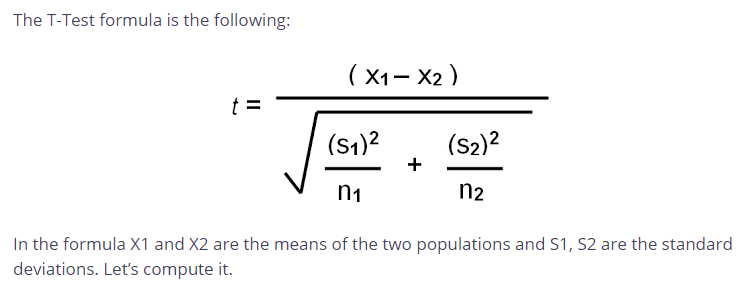

In [9]:
def get_t_value_independent_samples(sample1, sample2):
    return (sample1.mean() - sample2.mean()) / np.sqrt(get_variance(sample1)/len(sample1) + get_variance(sample2)/len(sample2))

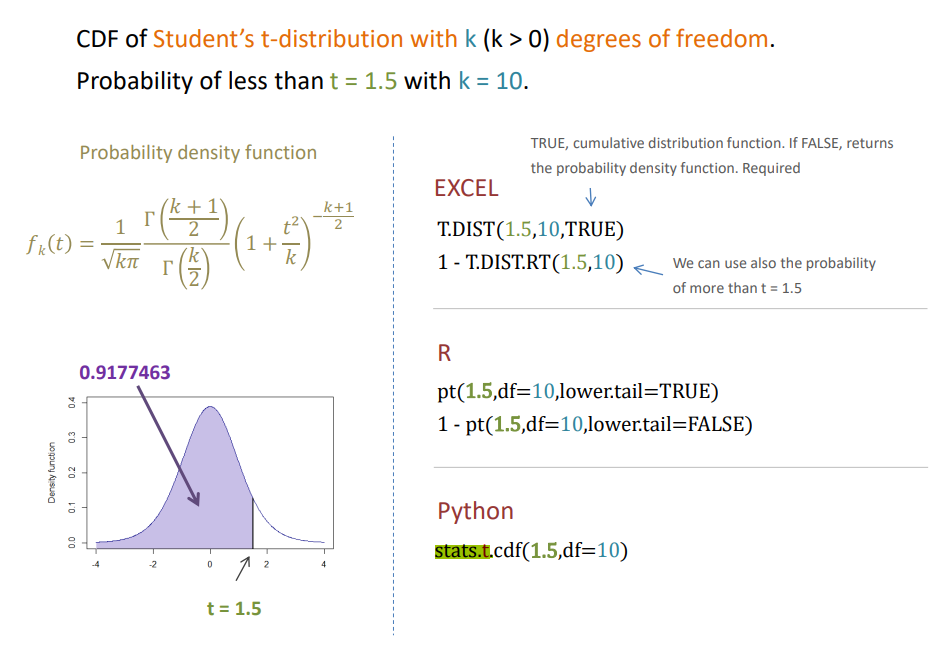

In [10]:
def get_p_value_independent_samples(group1, group2, t_value):
    df = len(group1) + len(group2) - 2
    return stats.t.cdf(t_value, df=df)

### **1.2.** Funkcja końcowa

In [11]:
def two_independent_samples(group1, group2, alpha = 0.05, power = 0.8):
  '''Input: (Group1, Group2, Alpha, Power)
  Group1 and Group2 as np.array
  Alpha as a float in range 0-1 (0.05 default value)
  Power as a float in range 0-1 (0.8 default value)'''
  cohen_d = get_cohen_d_independent_samples(group1, group2)
  min_sample_size = get_min_sample_size(d=cohen_d,power=power, alpha=alpha)
  
  group_1_samples = get_bootstrap_samples(min_sample_size, group1)
  group_2_samples = get_bootstrap_samples(min_sample_size, group2)

  t_value = get_t_value_independent_samples(group_1_samples, group_2_samples)
  p_value = get_p_value_independent_samples(group_1_samples, group_2_samples, t_value)

  return group_1_samples,group_2_samples, t_value, p_value

In [12]:
def Interactive_plot_independent(group1, group2):
  tb = widgets.TabBar([str(i) for i in range(1,10)])
  for i in range(0,9):
      with tb.output_to(i):
        power = (i+1) / 10
        group_1_samples, group_2_samples, t_value, p_value = two_independent_samples(group1, group2, 0.05, power=power)

        print(f'Bootstraped T-test results: (t-statistic={t_value}, pvalue={p_value})')
        predict_hypothesis(0.05, p_value)

        draw_two_histograms(group_1_samples,group_2_samples, f'Histogram for power = {power}')

### **1.3.** Próba dla zbioru "Fifa"

https://www.kaggle.com/karangadiya/fifa19



Porównanie ogólnej oceny piłkarzy w grze FIFA 19 pochodzących z Anglii (1. próba) i Hiszpanii (2. próba)

In [13]:
fifa_df = pd.read_csv('Fifa.csv')
fifa_df = fifa_df.drop(['Photo', 'Flag', 'Club Logo'], axis =1)
overall_df= fifa_df[['Overall', 'Nationality']].dropna()
#Selects Overall From English Born Players
overall_eng = overall_df[overall_df['Nationality'].str.contains("England")==True]
#Selects Overall From Spanish Born Players
overall_spa = overall_df[overall_df['Nationality'].str.contains("Spain")==True]

#English
english_ov_df = overall_eng['Overall']
english_overall = np.array(english_ov_df)
#Spanish
spanish_ov_df = overall_spa['Overall']
spanish_overall = np.array(spanish_ov_df)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=36.663487206317676, pvalue=1.0)
nie ma podstaw do odrzucenia hipotezy zerowej


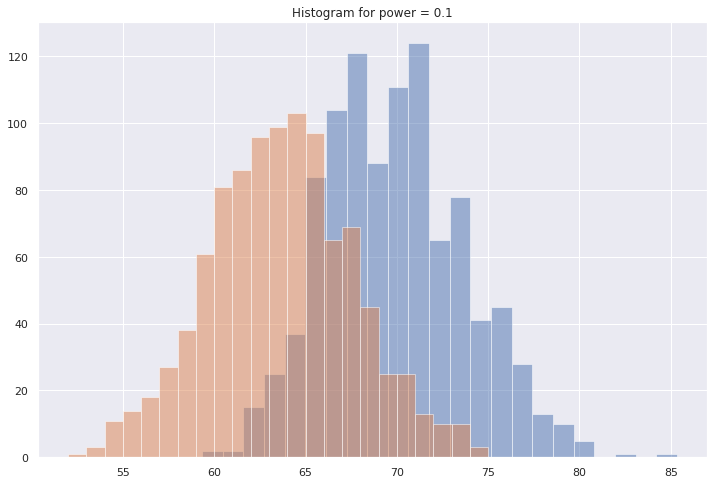

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=42.647257016659125, pvalue=1.0)
nie ma podstaw do odrzucenia hipotezy zerowej


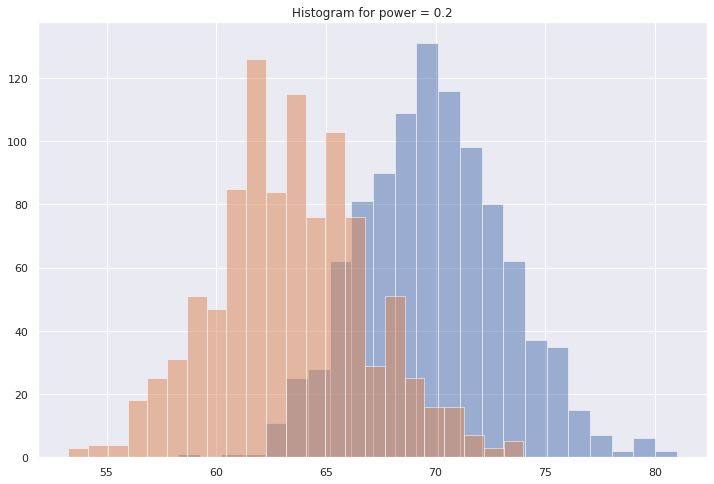

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=50.545462524083874, pvalue=1.0)
nie ma podstaw do odrzucenia hipotezy zerowej


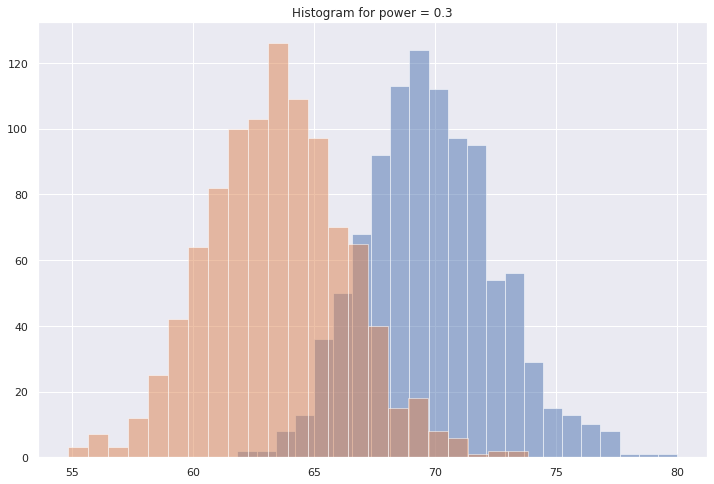

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=59.202182984523255, pvalue=1.0)
nie ma podstaw do odrzucenia hipotezy zerowej


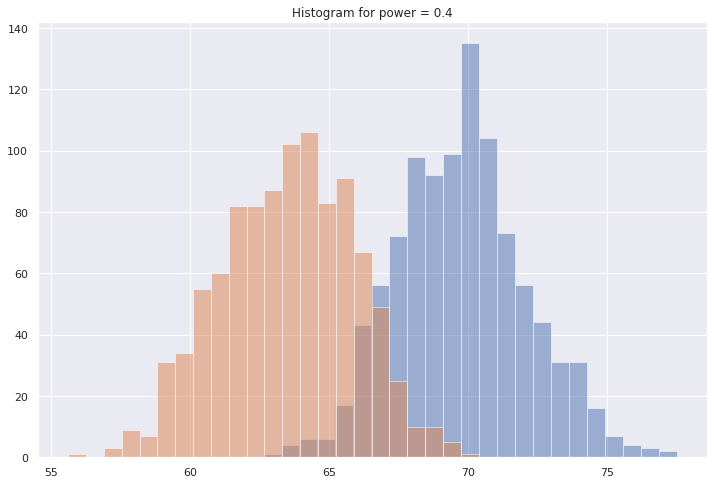

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=65.71448158166623, pvalue=1.0)
nie ma podstaw do odrzucenia hipotezy zerowej


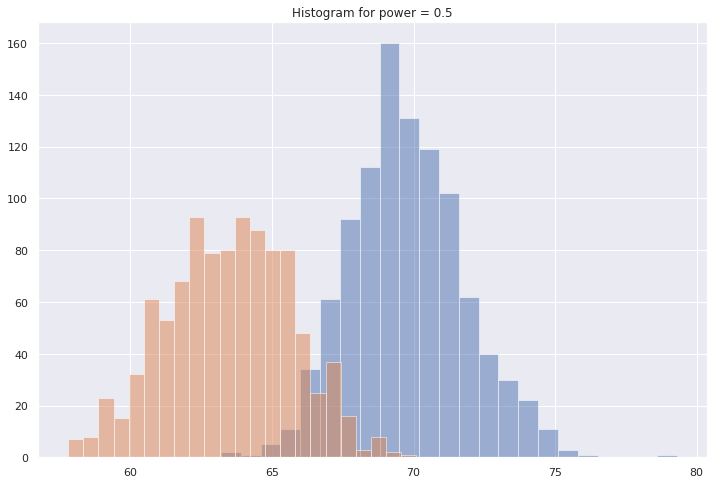

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=75.45356248327884, pvalue=1.0)
nie ma podstaw do odrzucenia hipotezy zerowej


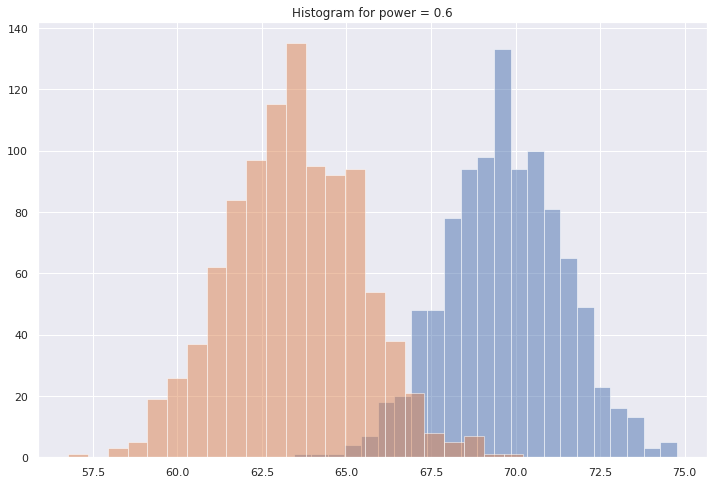

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=81.47737279450816, pvalue=1.0)
nie ma podstaw do odrzucenia hipotezy zerowej


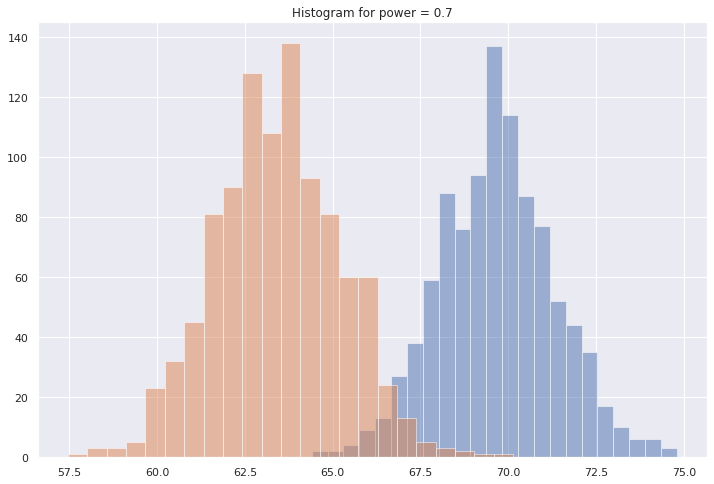

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=94.54121339545978, pvalue=1.0)
nie ma podstaw do odrzucenia hipotezy zerowej


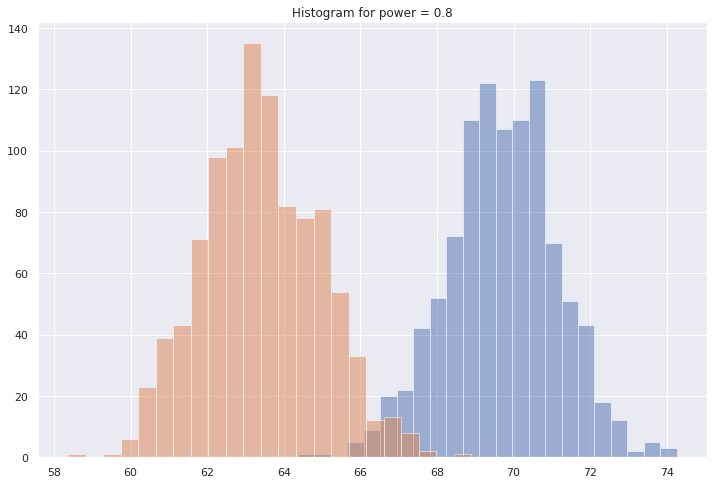

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=107.3523422781093, pvalue=1.0)
nie ma podstaw do odrzucenia hipotezy zerowej


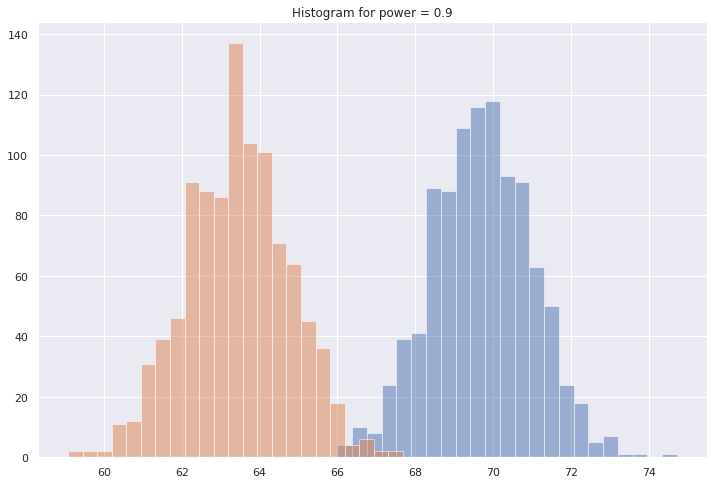

<IPython.core.display.Javascript object>

In [14]:
Interactive_plot_independent(spanish_overall, english_overall)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-36.663487206317676, pvalue=8.57114507486159e-226)
odrzucamy hipotezę zerową


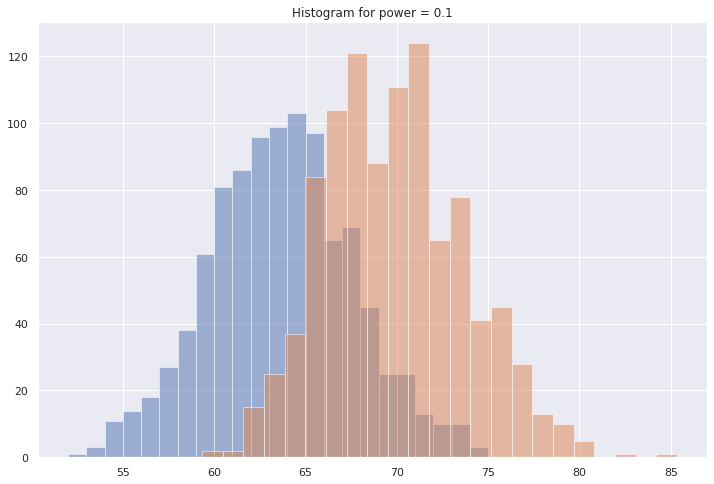

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-42.647257016659125, pvalue=1.9487927790942805e-283)
odrzucamy hipotezę zerową


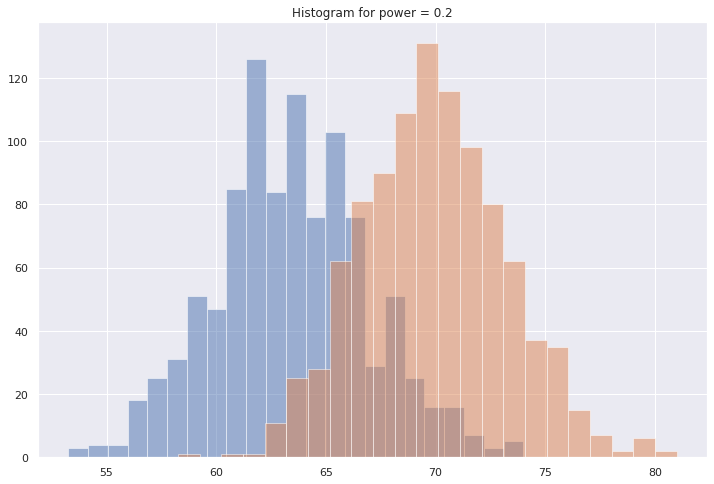

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-50.545462524083874, pvalue=0.0)
odrzucamy hipotezę zerową


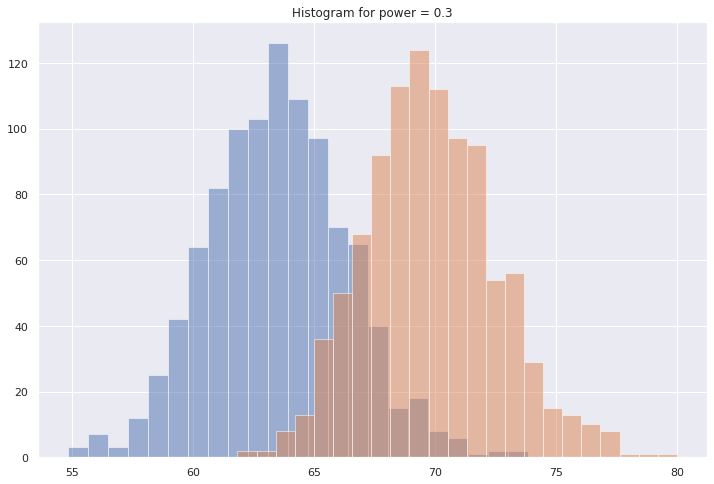

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-59.202182984523255, pvalue=0.0)
odrzucamy hipotezę zerową


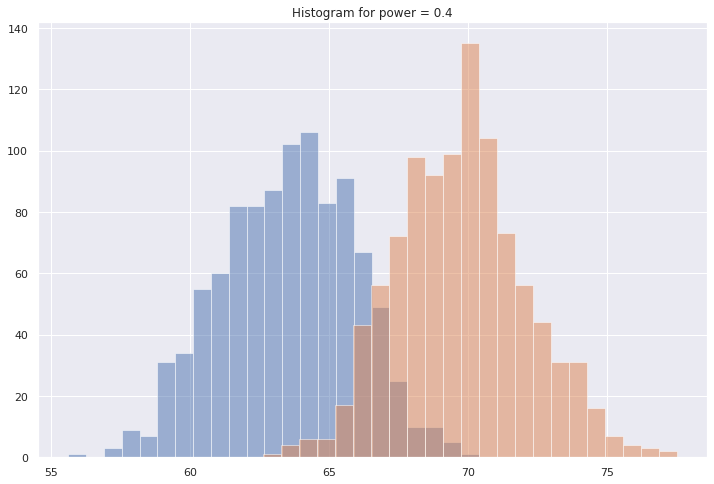

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-65.71448158166623, pvalue=0.0)
odrzucamy hipotezę zerową


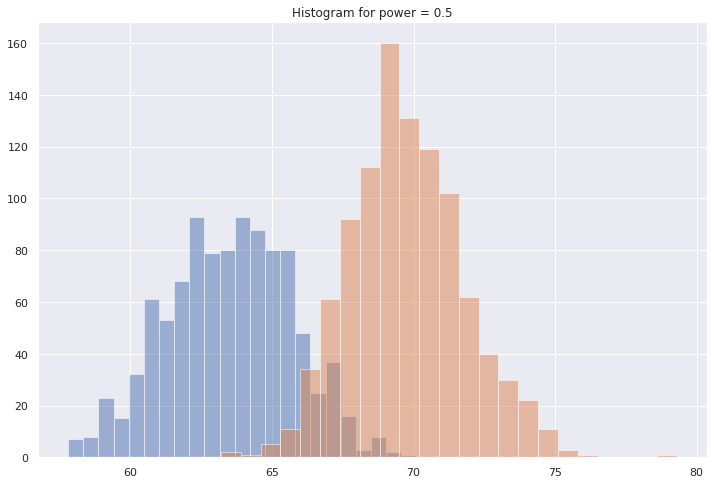

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-75.45356248327884, pvalue=0.0)
odrzucamy hipotezę zerową


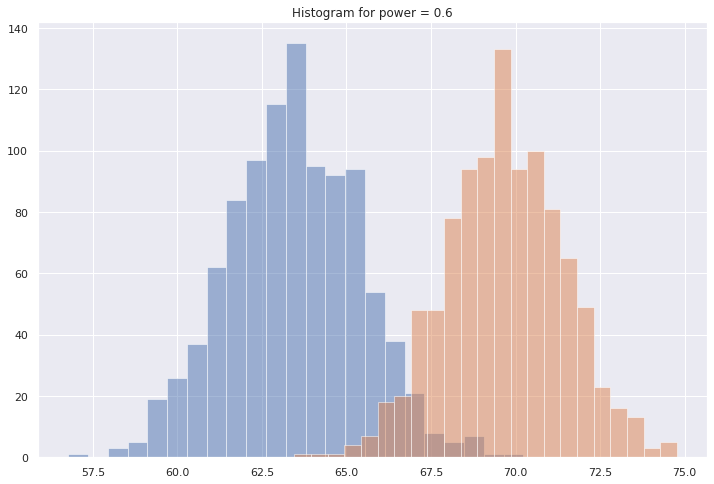

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-81.47737279450816, pvalue=0.0)
odrzucamy hipotezę zerową


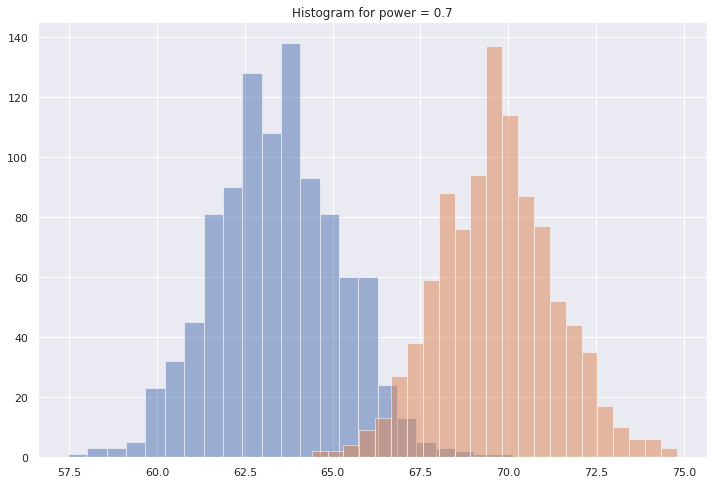

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-94.54121339545978, pvalue=0.0)
odrzucamy hipotezę zerową


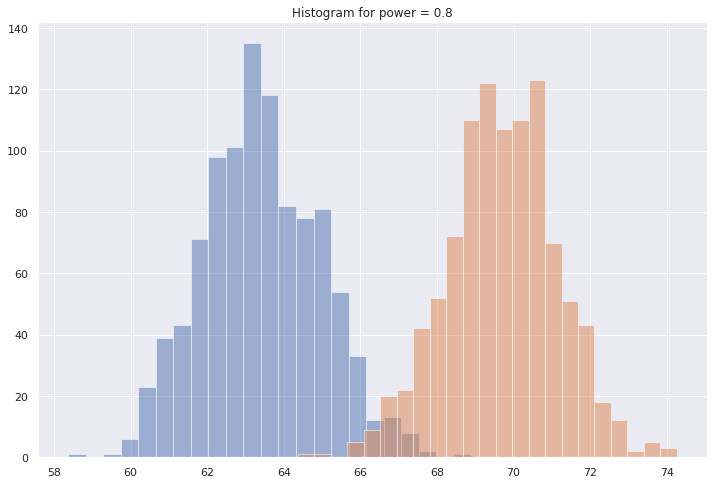

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-107.3523422781093, pvalue=0.0)
odrzucamy hipotezę zerową


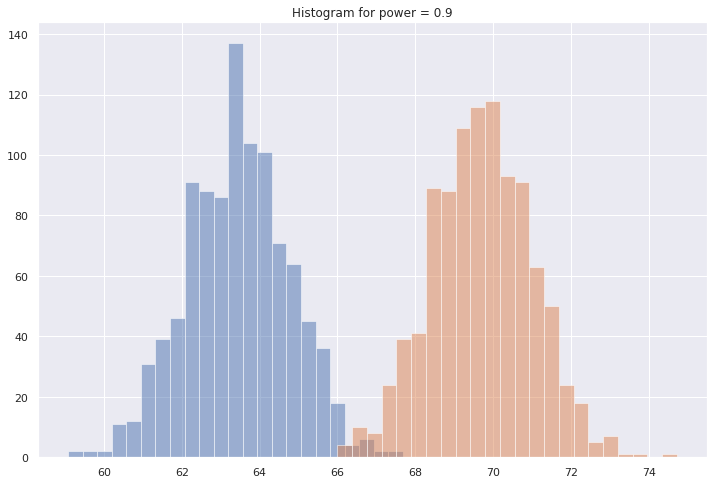

<IPython.core.display.Javascript object>

In [15]:
Interactive_plot_independent(english_overall, spanish_overall)

### **1.4.** Próba dla zbioru "Pokemon"

https://www.kaggle.com/abcsds/pokemon

Porównanie pokemonów typu wodnego z pokemonami typu trawiastego pod względem sumy wszystkich statystyk (+ bonusowo typ Dark z typem Dragon)

In [16]:
pokemon_df = pd.read_csv('Pokemon.csv')
pokemon_df.head()

overall_df= pokemon_df[['Total', 'Type 1']].dropna()

overall_water = overall_df[overall_df['Type 1'].str.contains("Water")==True]
 
overall_grass = overall_df[overall_df['Type 1'].str.contains("Grass")==True]

overall_dark = overall_df[overall_df['Type 1'].str.contains("Dark")==True]
 
overall_dragon = overall_df[overall_df['Type 1'].str.contains("Dragon")==True]
 
water_ov_df = overall_water['Total']
water_overall = np.array(water_ov_df)
 
grass_ov_df = overall_grass['Total']
grass_overall = np.array(grass_ov_df)

dark_ov_df = overall_dark['Total']
dark_overall = np.array(dark_ov_df)
 
dragon_ov_df = overall_dragon['Total']
dragon_overall = np.array(dragon_ov_df)

#### **1.4.1** Water vs Grass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=21.89127772498707, pvalue=1.0)
nie ma podstaw do odrzucenia hipotezy zerowej


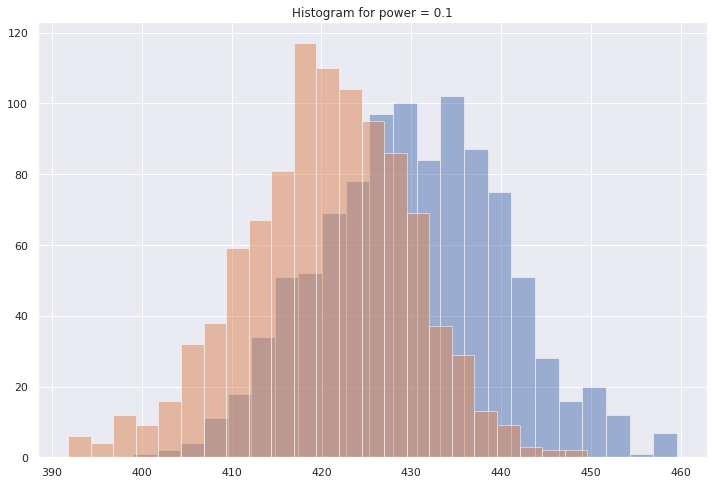

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=33.29381619997132, pvalue=1.0)
nie ma podstaw do odrzucenia hipotezy zerowej


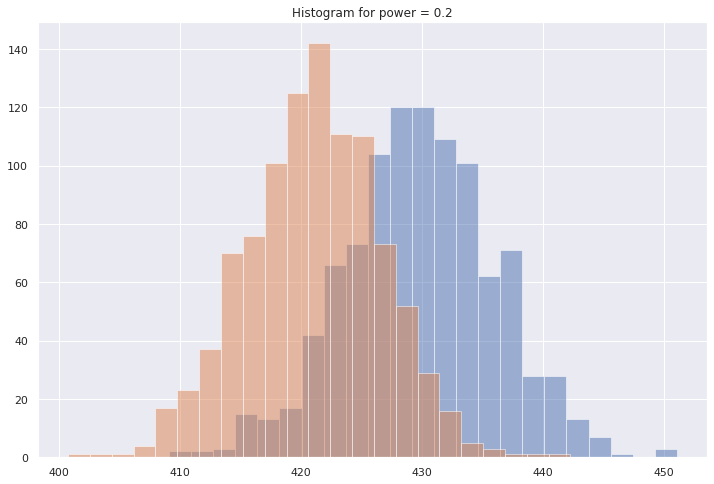

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=45.00098565729797, pvalue=1.0)
nie ma podstaw do odrzucenia hipotezy zerowej


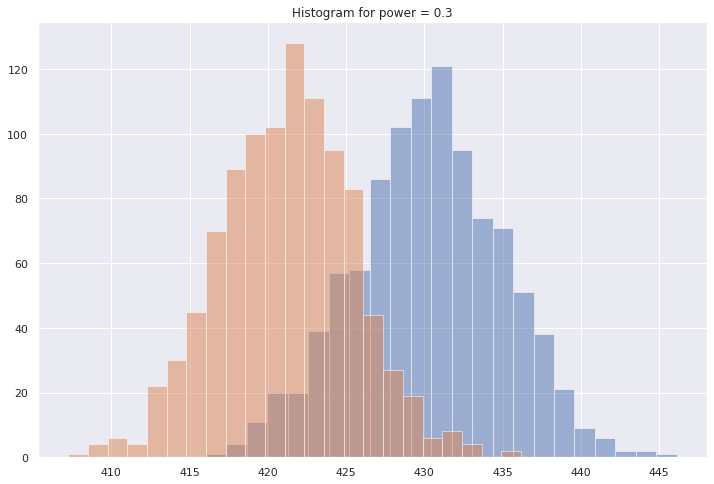

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=53.92861400208955, pvalue=1.0)
nie ma podstaw do odrzucenia hipotezy zerowej


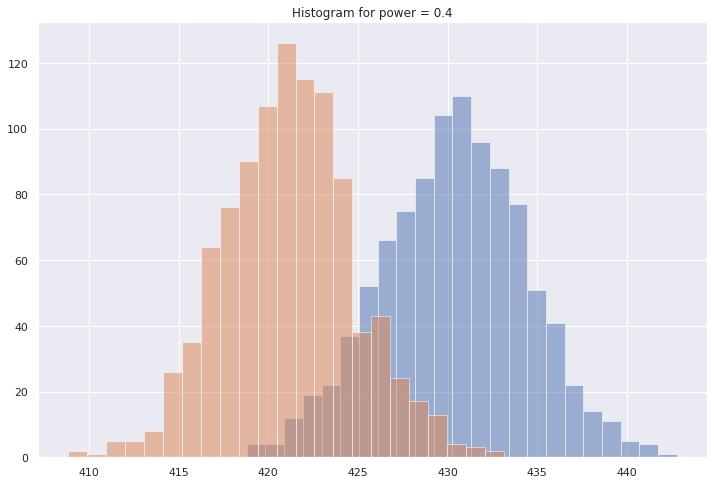

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=62.63073042211412, pvalue=1.0)
nie ma podstaw do odrzucenia hipotezy zerowej


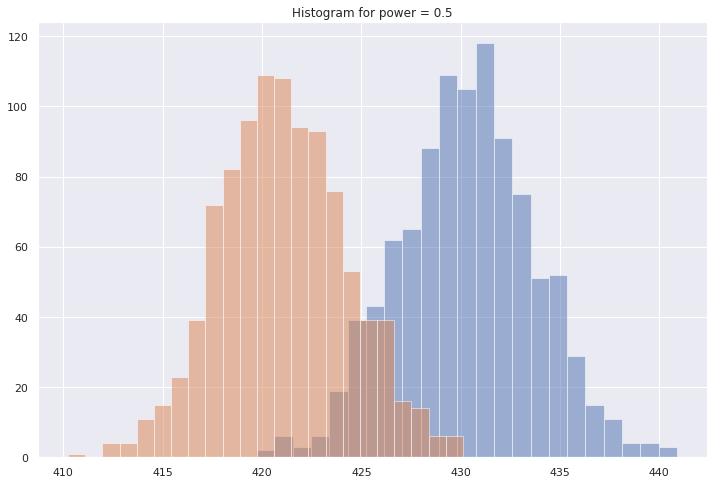

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=70.66603412647503, pvalue=1.0)
nie ma podstaw do odrzucenia hipotezy zerowej


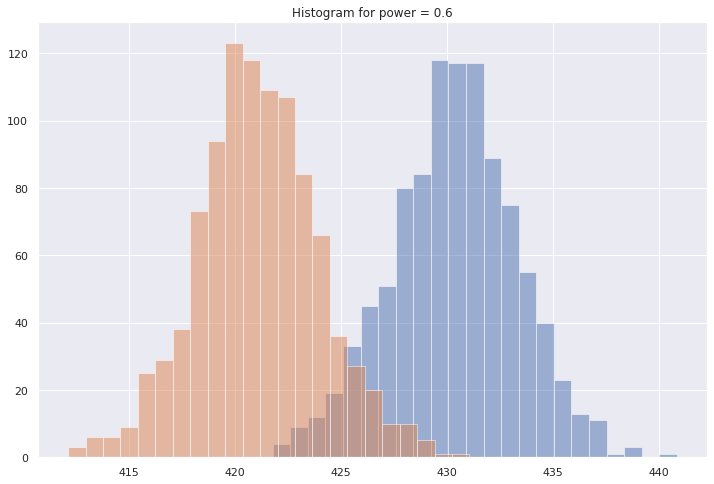

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=79.95698296627798, pvalue=1.0)
nie ma podstaw do odrzucenia hipotezy zerowej


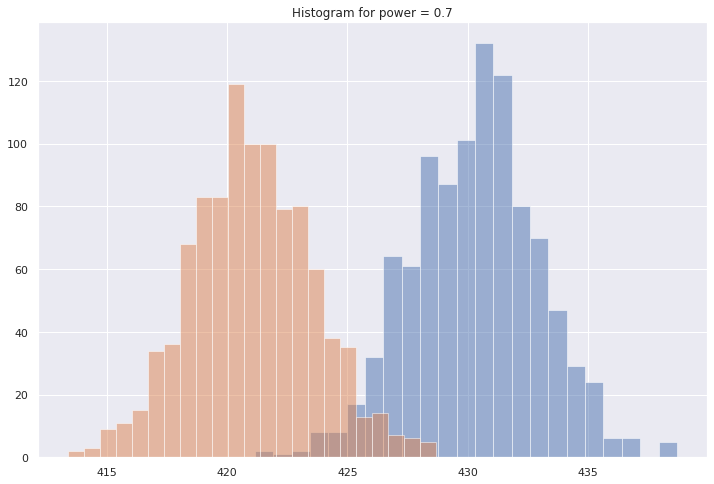

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=88.19880080059923, pvalue=1.0)
nie ma podstaw do odrzucenia hipotezy zerowej


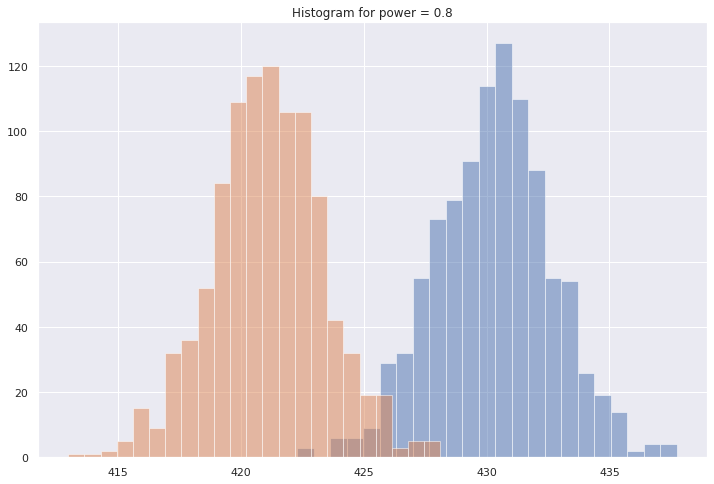

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=102.06864510222512, pvalue=1.0)
nie ma podstaw do odrzucenia hipotezy zerowej


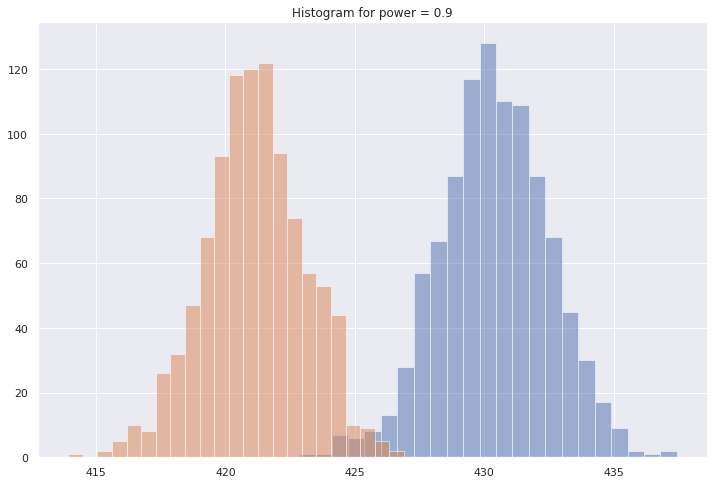

<IPython.core.display.Javascript object>

In [17]:
Interactive_plot_independent(water_overall, grass_overall)

#### **1.4.1** Dark vs Dragon

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-30.192697756690883, pvalue=1.3417792750054198e-165)
odrzucamy hipotezę zerową


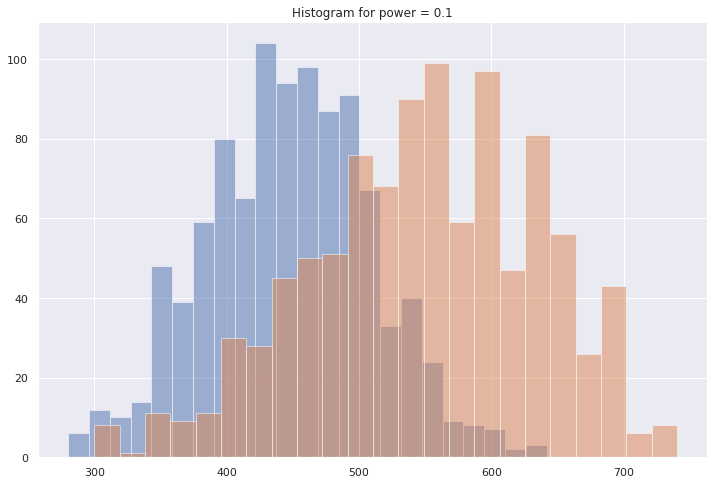

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-38.15456234295888, pvalue=4.7593854982498804e-240)
odrzucamy hipotezę zerową


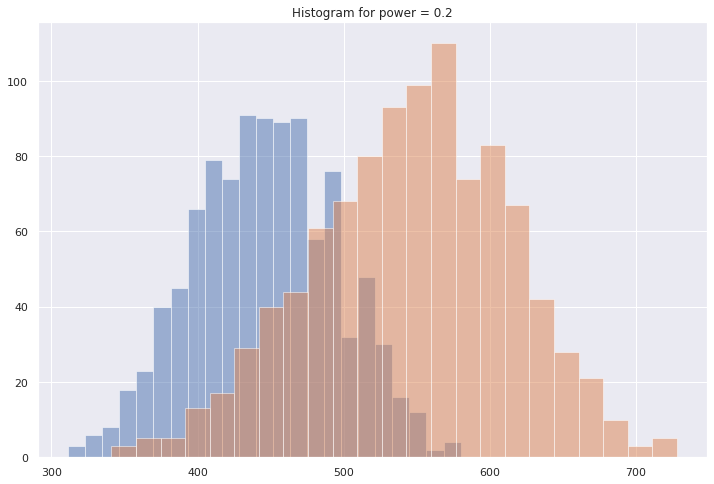

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-49.08592100614328, pvalue=0.0)
odrzucamy hipotezę zerową


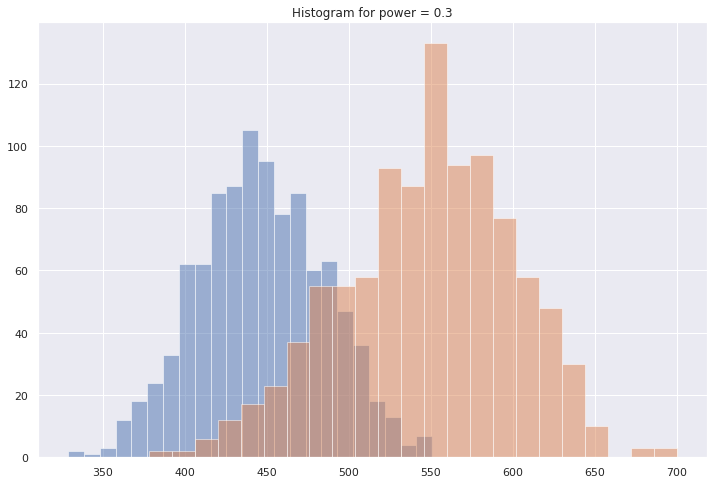

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-56.54233873653055, pvalue=0.0)
odrzucamy hipotezę zerową


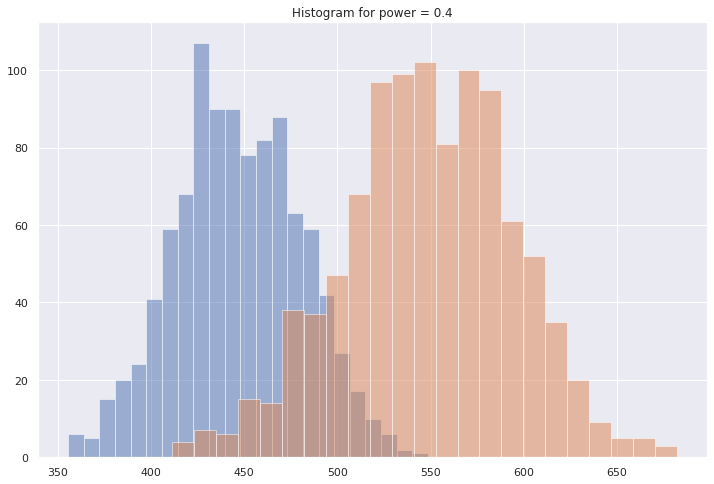

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-66.15094134713821, pvalue=0.0)
odrzucamy hipotezę zerową


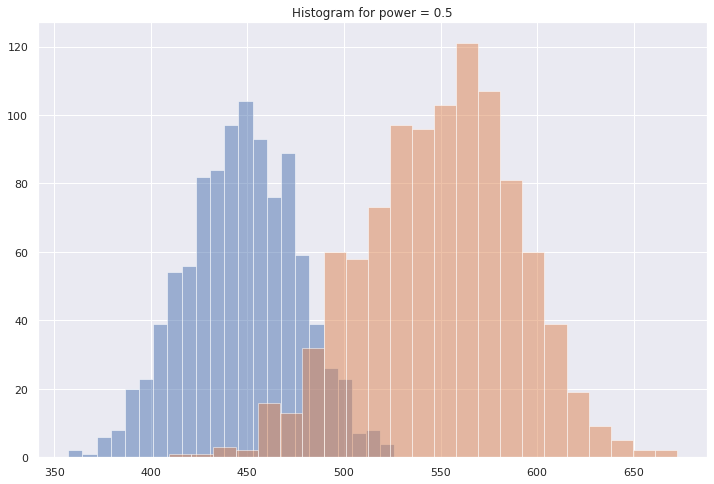

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-72.71443815098893, pvalue=0.0)
odrzucamy hipotezę zerową


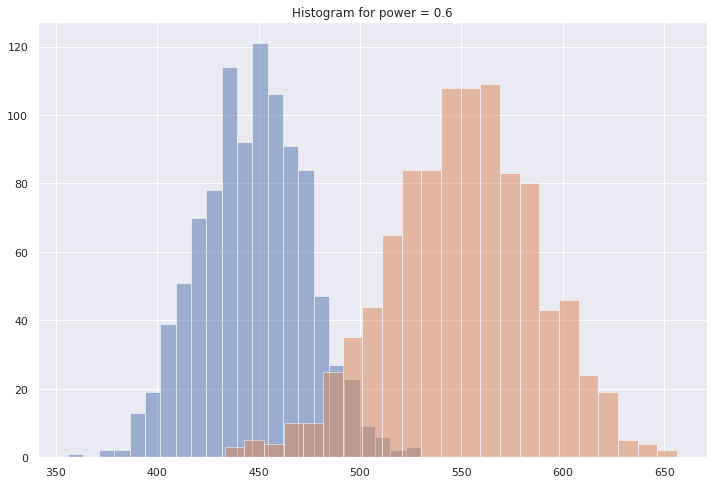

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-81.9924068257253, pvalue=0.0)
odrzucamy hipotezę zerową


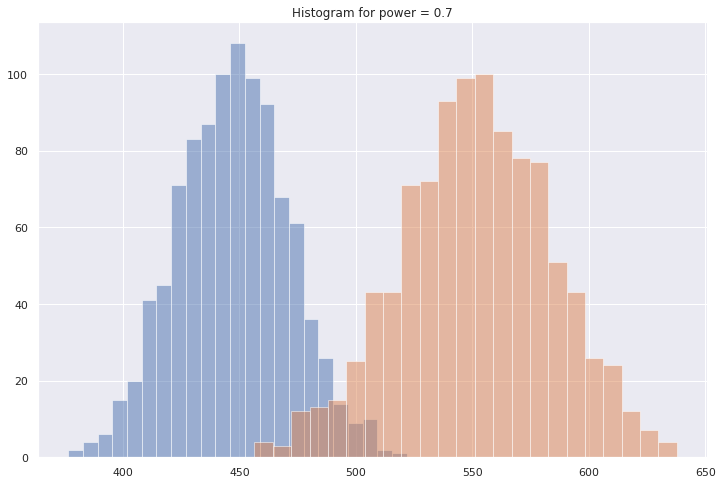

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-89.91119488102005, pvalue=0.0)
odrzucamy hipotezę zerową


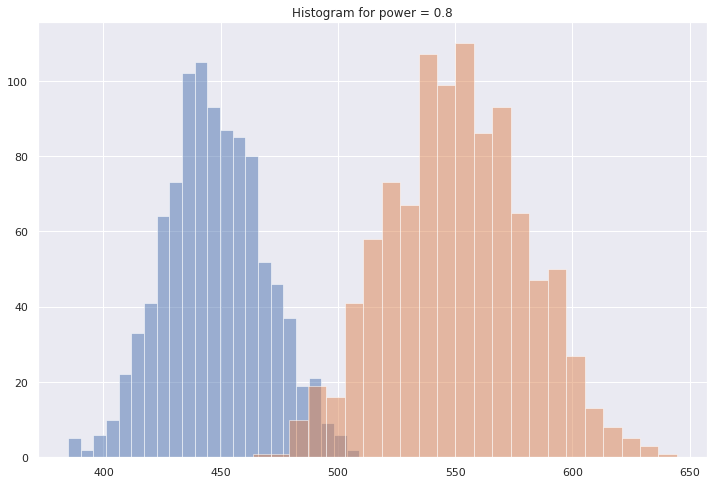

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-100.31323014993114, pvalue=0.0)
odrzucamy hipotezę zerową


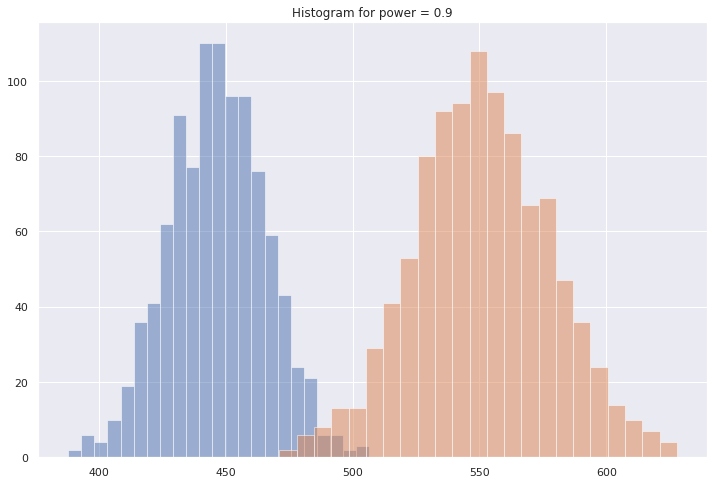

<IPython.core.display.Javascript object>

In [18]:
Interactive_plot_independent(dark_overall, dragon_overall)

# 2. *Wersja dla dwóch prób zależnych*

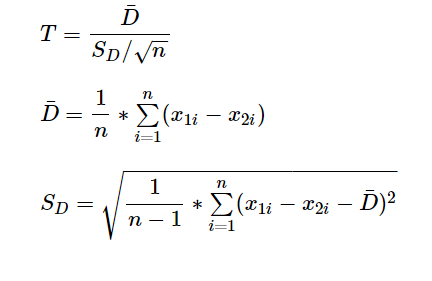

### **2.1.** Funkcje pośrednie

In [19]:
def get_cohen_d_paired_samples(sample1, sample2):
    mean_difference = np.sum(sample1 - sample2) / len(sample1)
    sd = np.sqrt(get_variance(sample1 - sample2))
    return mean_difference / sd

In [20]:
def get_t_value_paired_samples(sample1, sample2):
    n = len(sample1)
    d = (1 / n) * np.sum(sample1 - sample2)
    sd = np.sqrt((1/(n-1)) * np.sum((sample1 - sample2 - d)**2))
    t = d / (sd / np.sqrt(n))
    return t

In [21]:
def get_p_value_paired_samples(t_value, df):
    leng = len(df) - 1
    return stats.t.cdf(t_value, df=leng)

### **2.2.** Funkcja końcowa

In [22]:
def two_paired_samples(group1, group2, alpha = 0.05, power = 0.8):
  '''Input: (Group1, Group2, Alpha, Power)
  Group1 and Group2 as np.array
  Alpha as a float in range 0-1 (0.05 default value)
  Power as a float in range 0-1 (0.8 default value)'''
  cohen_d = get_cohen_d_paired_samples(group1, group2)
  min_sample_size = get_min_sample_size(cohen_d, power, alpha)
  
  group_1_samples = get_bootstrap_samples(min_sample_size, group1)
  group_2_samples = get_bootstrap_samples(min_sample_size, group2)

  t_value = get_t_value_paired_samples(group_1_samples, group_2_samples)
  p_value = get_p_value_paired_samples(t_value, group_1_samples)

  return group_1_samples,group_2_samples, t_value, p_value

In [23]:
def Interactive_plot_paired(group1, group2):
  tb = widgets.TabBar([str(i) for i in range(1,10)])
  for i in range(0,9):
      with tb.output_to(i):
        power = (i+1) / 10
        group_1_samples, group_2_samples, t_value, p_value = two_paired_samples(group1, group2, 0.05, power=power)

        print(f'Bootstraped T-test results: (t-statistic={t_value}, pvalue={p_value})')
        predict_hypothesis(0.05, p_value)

        draw_two_histograms(group_1_samples,group_2_samples, f'Histogram for power = {power}')

### **2.3.** Próba dla zbioru "Beers"

http://media.news.health.ufl.edu/misc/bolt/Intro/files/unit4/Mod13Data/beers.csv

Badanie zmiany czasu reakcji kierowców przed i po wypiciu dwóch piw

In [24]:
beers_df = pd.read_csv('Beer.csv')
beers_before = np.array(beers_df['Before'])
beers_after = np.array(beers_df['After'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-38.69647005558417, pvalue=3.4260126030976856e-201)
odrzucamy hipotezę zerową


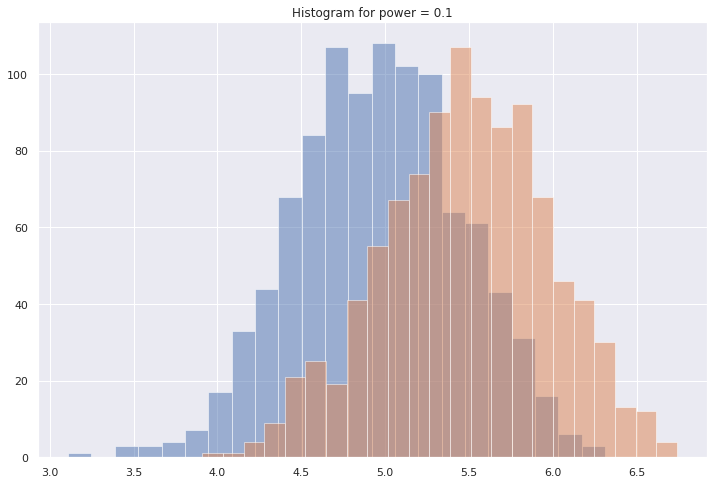

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-56.86730416599922, pvalue=8.65196237e-316)
odrzucamy hipotezę zerową


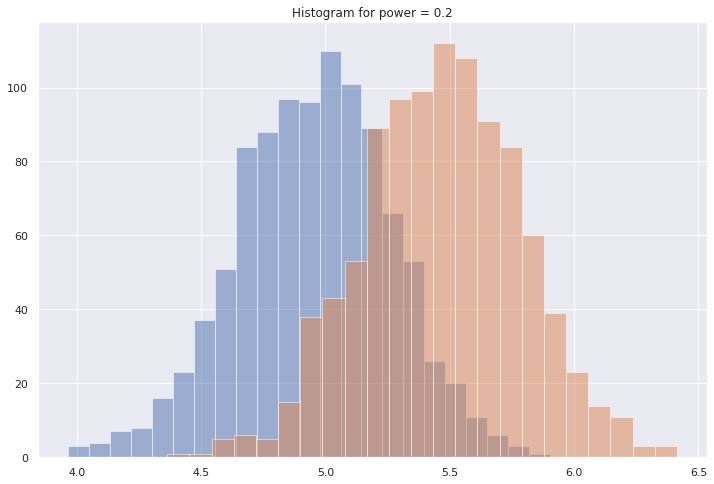

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-69.43233602696235, pvalue=0.0)
odrzucamy hipotezę zerową


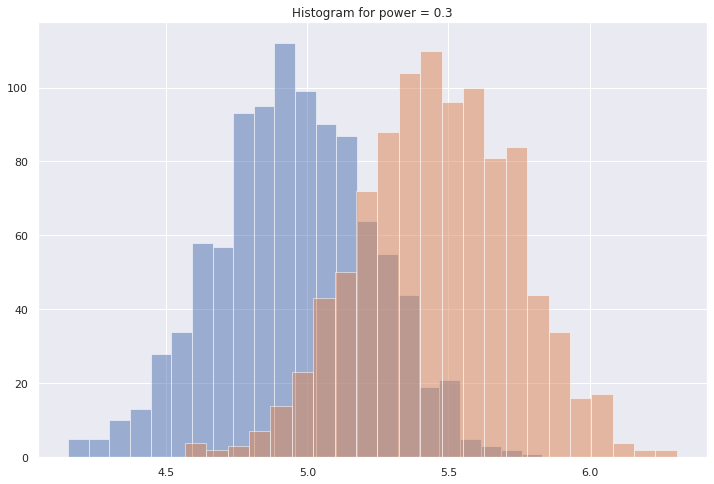

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-79.00834827286847, pvalue=0.0)
odrzucamy hipotezę zerową


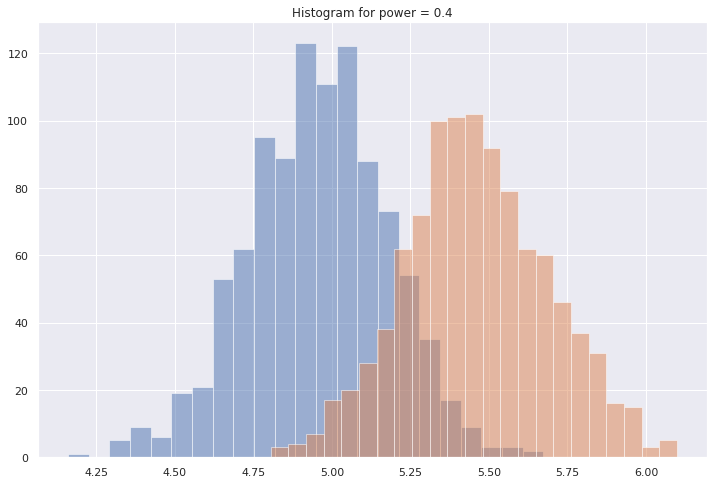

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-85.7415555146318, pvalue=0.0)
odrzucamy hipotezę zerową


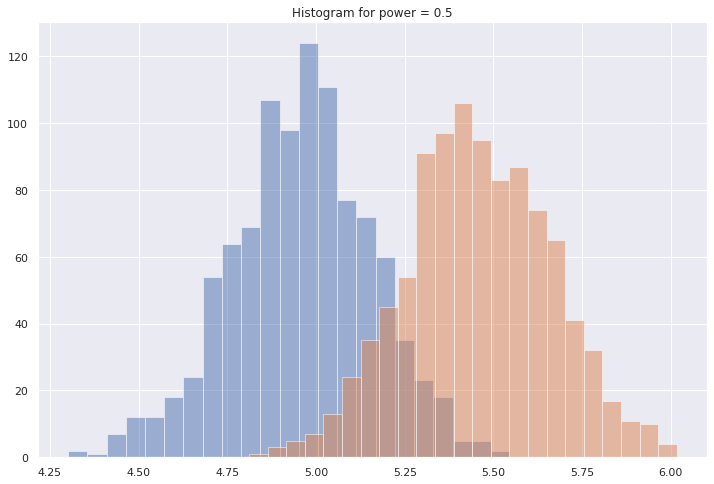

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-100.95277236694622, pvalue=0.0)
odrzucamy hipotezę zerową


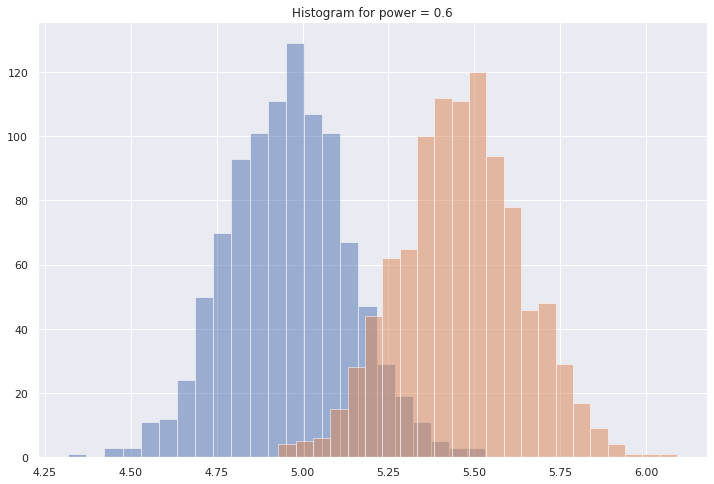

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-111.8066601001458, pvalue=0.0)
odrzucamy hipotezę zerową


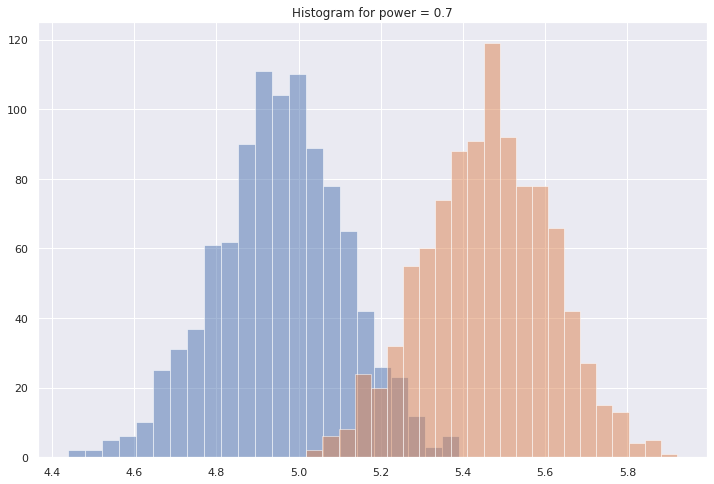

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-123.83798277653972, pvalue=0.0)
odrzucamy hipotezę zerową


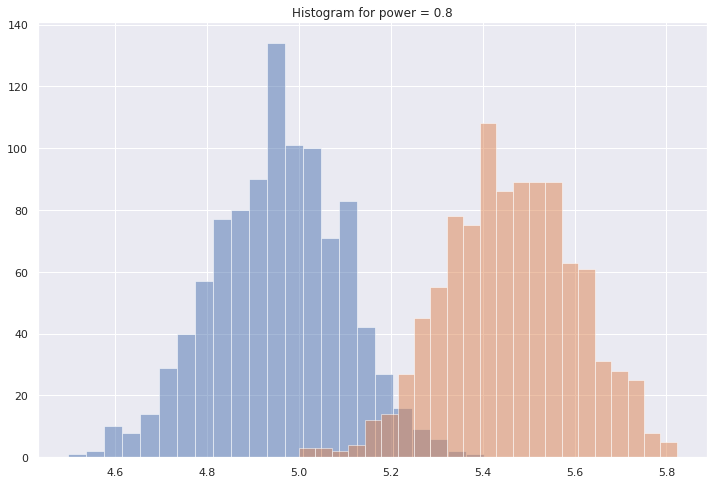

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-142.68024569261308, pvalue=0.0)
odrzucamy hipotezę zerową


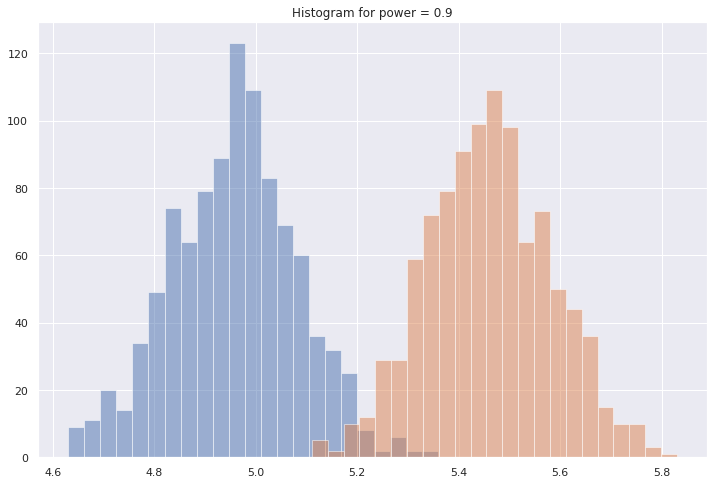

<IPython.core.display.Javascript object>

In [25]:
Interactive_plot_paired(beers_before, beers_after)

### **2.4.** Próba dla zbioru "Drugs"

https://www.kaggle.com/steveahn/memory-test-on-drugged-islanders-data

Badanie czasu wykonania testu pamięciowego przed i po zażyciu leków przeciwlękowych

In [26]:
drugs_df = pd.read_csv('Drugs.csv')
drugs_before = np.array(drugs_df['Mem_Score_Before'])
drugs_after = np.array(drugs_df['Mem_Score_After'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-31.14082561082293, pvalue=1.2274302933466692e-149)
odrzucamy hipotezę zerową


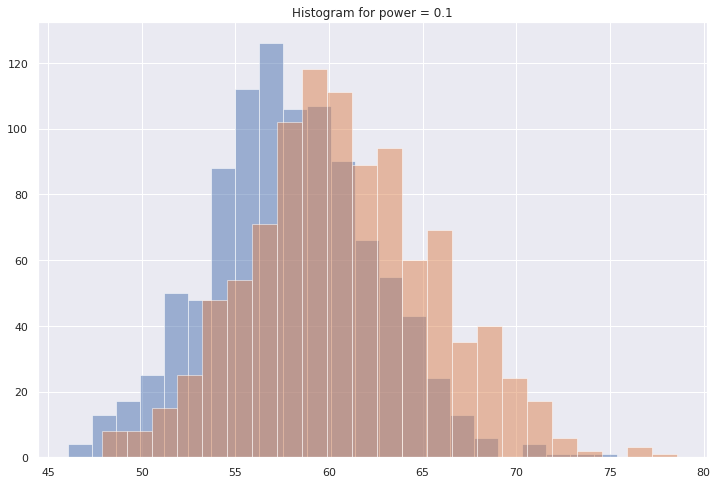

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-48.131982582823206, pvalue=8.612332445832746e-263)
odrzucamy hipotezę zerową


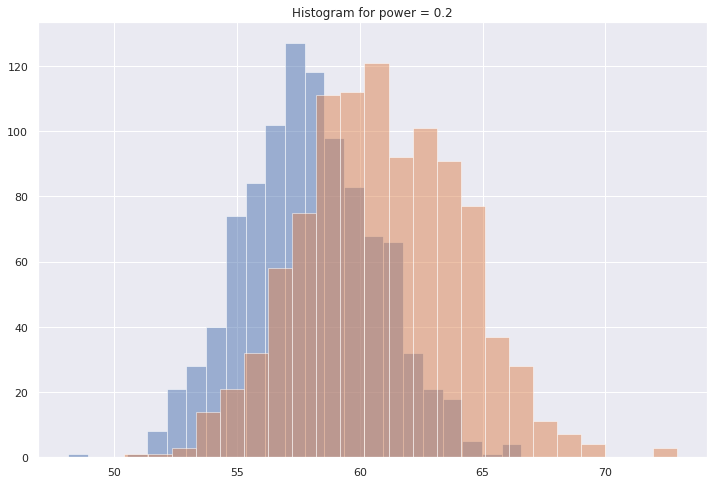

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-64.59180374243522, pvalue=0.0)
odrzucamy hipotezę zerową


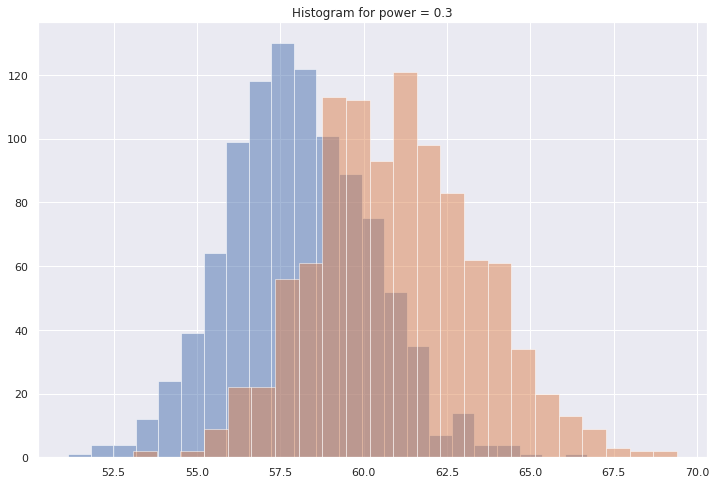

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-73.58889072580766, pvalue=0.0)
odrzucamy hipotezę zerową


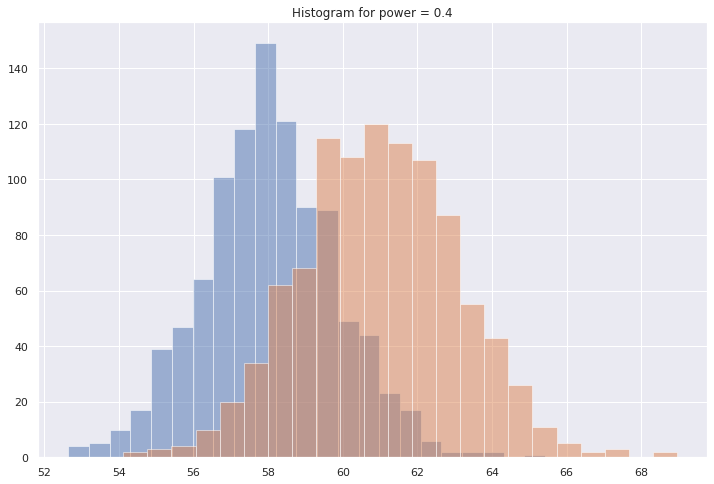

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-87.37449394390279, pvalue=0.0)
odrzucamy hipotezę zerową


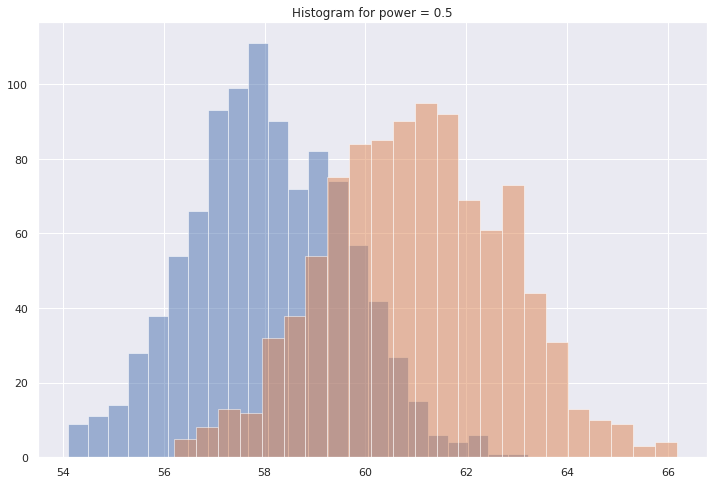

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-100.5136609107648, pvalue=0.0)
odrzucamy hipotezę zerową


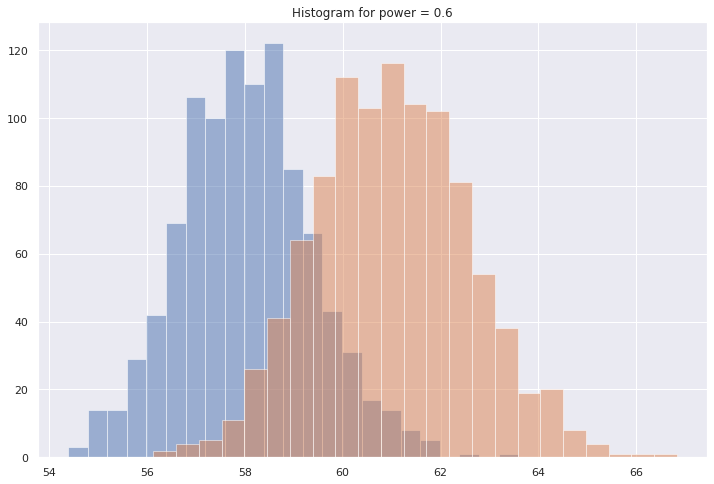

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-113.26251794225271, pvalue=0.0)
odrzucamy hipotezę zerową


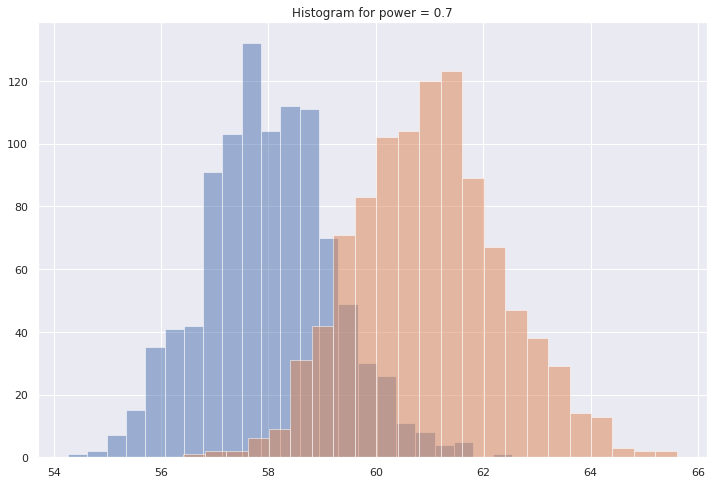

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-124.49207069810441, pvalue=0.0)
odrzucamy hipotezę zerową


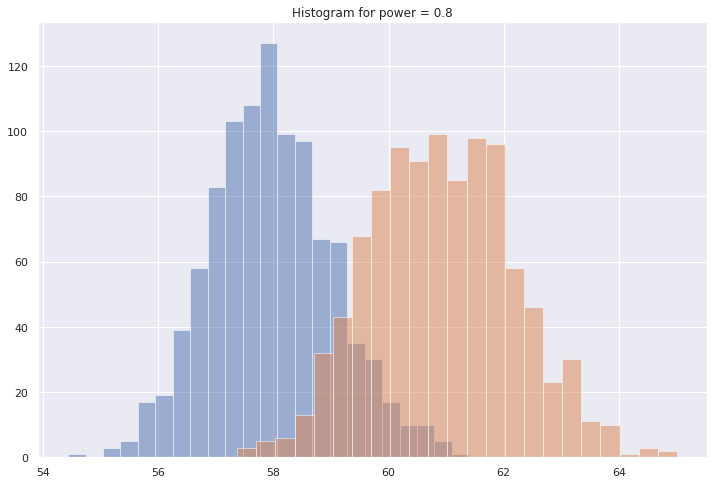

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-145.78471993792004, pvalue=0.0)
odrzucamy hipotezę zerową


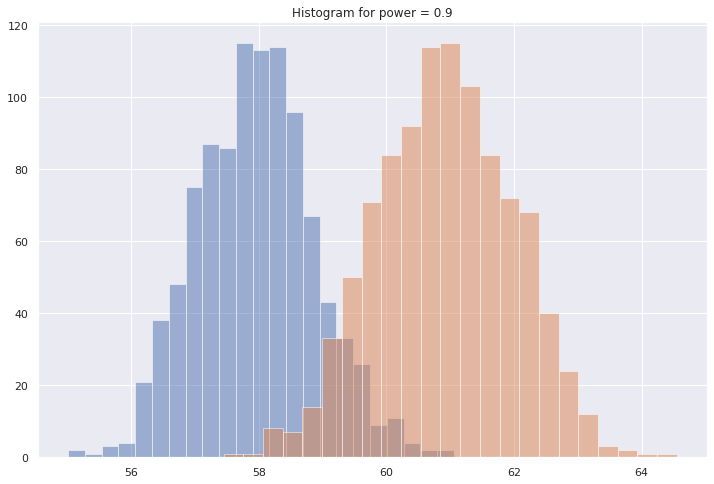

<IPython.core.display.Javascript object>

In [27]:
Interactive_plot_paired(drugs_before, drugs_after)

# 3. *Wersja dla jednej próby*

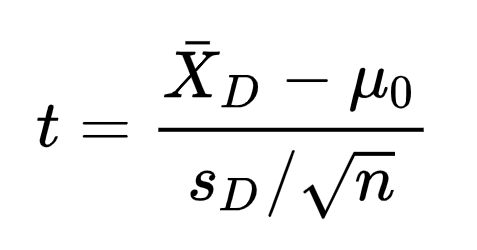

### **3.1.** Funckje Pośrednie

In [28]:
def get_cohen_d_one_sample(sample, value):
    mean = sample.mean()
    return (mean - value) / np.sqrt((1/(len(sample)-1)) * np.sum((sample - mean)**2))

In [29]:
def get_t_value_one_samples(sample, value):
    return (sample.mean() - value) / (np.sqrt(get_variance(sample)) / np.sqrt(len(sample))) 

In [30]:
def get_p_value_independent_samples(group, t_value):
    df = len(group) - 1
    return stats.t.sf(t_value, df=df) * 2

### **3.2.** Końcowa funkcja

In [31]:
def one_sample(group1, value, alpha = 0.05, power = 0.8):
  '''Input: (Group1, Alpha, Power, Value)
  Group1 as np.array
  Alpha as a float in range 0-1 (0.05 default value)
  Power as a float in range 0-1 (0.8 default value)'''
  cohen_d = get_cohen_d_one_sample(group1, value)
  min_sample_size = get_min_sample_size(cohen_d, power, alpha)
  
  group_1_samples = get_bootstrap_samples(min_sample_size, group1)

  t_value = get_t_value_one_samples(group_1_samples, value)
  p_value = get_p_value_independent_samples( group_1_samples, t_value)

  return group_1_samples, t_value, p_value

In [32]:
def Interactive_plot_one_sample(group1, value):
  tb = widgets.TabBar([str(i) for i in range(1,10)])
  for i in range(0,9):
      with tb.output_to(i):
        power = (i+1) / 10
        group_1_samples, t_value, p_value = one_sample(group1, value, 0.05, power=power)

        print(f'Bootstraped T-test results: (t-statistic={t_value}, pvalue={p_value})')
        predict_hypothesis(0.05, p_value)

        draw_histogram(group_1_samples, f'Histogram for power = {power}')

### **3.3.** Próba dla zbioru "Fat"

https://statisticsbyjim.com/hypothesis-testing/bootstrapping/

Zbiór zawierający procentowy poziom tkanki tłuszczowej u 92 nastolatek

In [33]:
body_fat_df = pd.read_csv('Fat.csv')
body_fat = np.array(body_fat_df['%Fat'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-28.91815650731031, pvalue=2.0)
nie ma podstaw do odrzucenia hipotezy zerowej


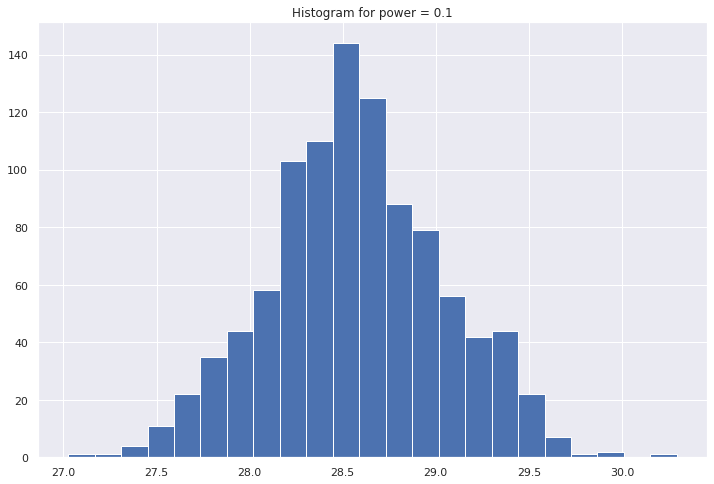

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-51.08399203668698, pvalue=2.0)
nie ma podstaw do odrzucenia hipotezy zerowej


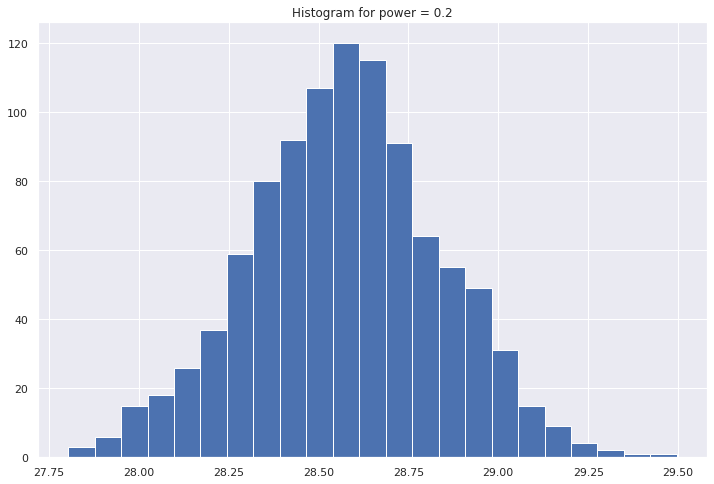

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-64.80379160309137, pvalue=2.0)
nie ma podstaw do odrzucenia hipotezy zerowej


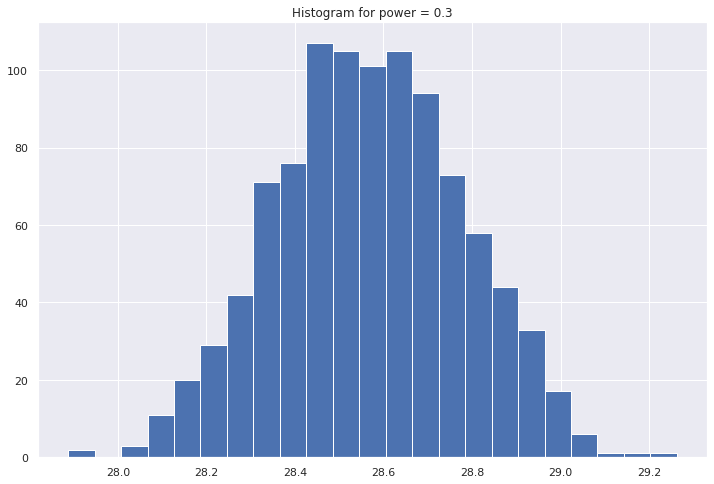

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-74.82742826503772, pvalue=2.0)
nie ma podstaw do odrzucenia hipotezy zerowej


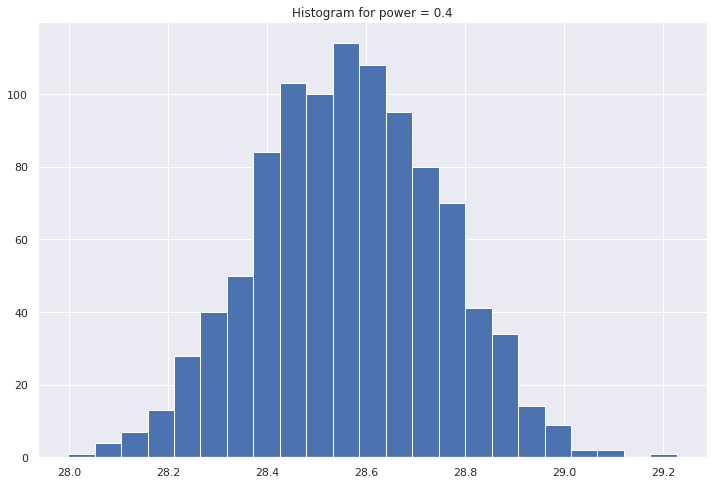

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-86.8934517658495, pvalue=2.0)
nie ma podstaw do odrzucenia hipotezy zerowej


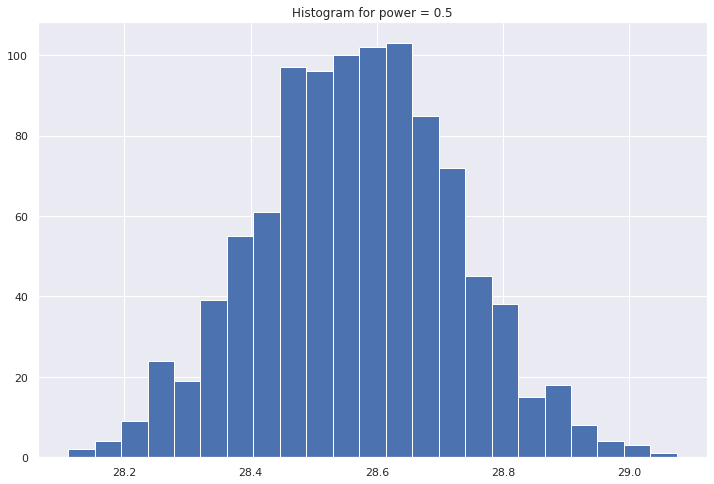

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-96.64905502828081, pvalue=2.0)
nie ma podstaw do odrzucenia hipotezy zerowej


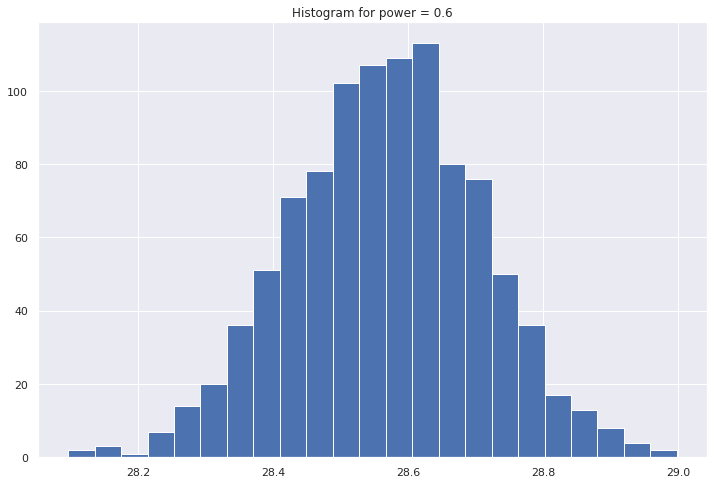

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-109.58679057143964, pvalue=2.0)
nie ma podstaw do odrzucenia hipotezy zerowej


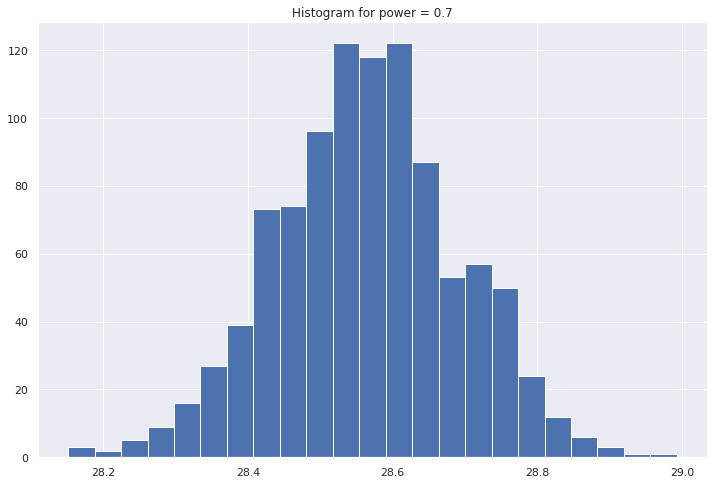

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-122.22652799066543, pvalue=2.0)
nie ma podstaw do odrzucenia hipotezy zerowej


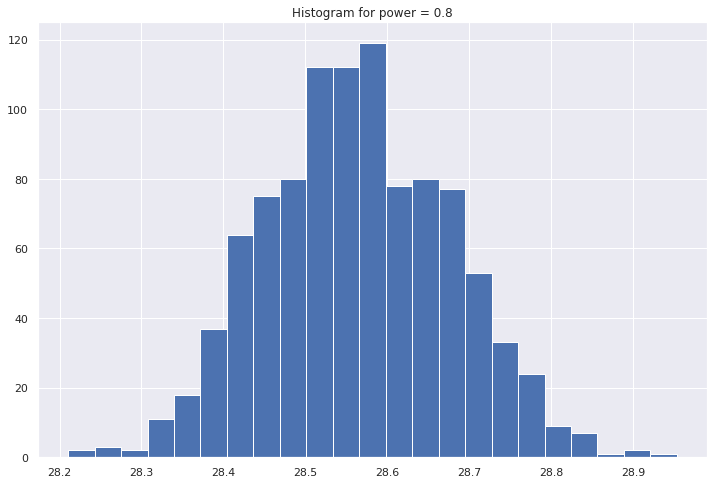

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-144.39934975697327, pvalue=2.0)
nie ma podstaw do odrzucenia hipotezy zerowej


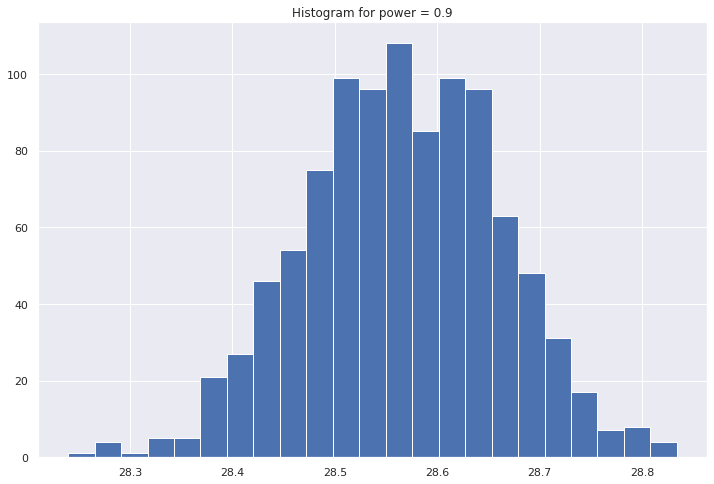

<IPython.core.display.Javascript object>

In [34]:
Interactive_plot_one_sample(body_fat, 29)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=36.224809378866695, pvalue=3.6922865163733164e-184)
odrzucamy hipotezę zerową


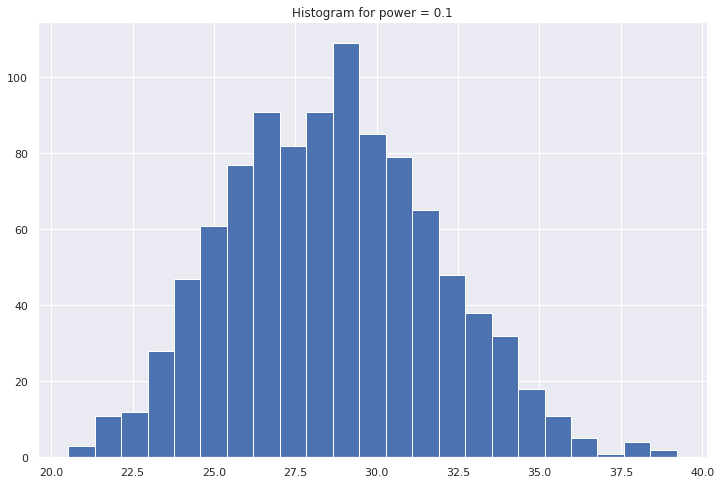

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=53.442911661636145, pvalue=3.3316635768725874e-295)
odrzucamy hipotezę zerową


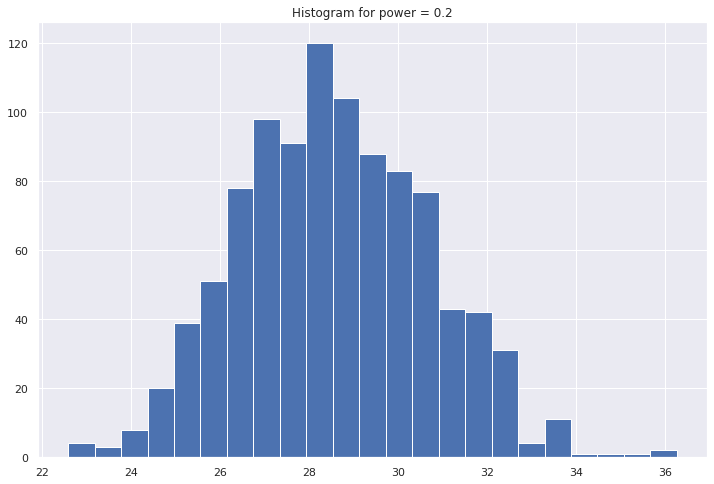

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=65.16326363421439, pvalue=0.0)
odrzucamy hipotezę zerową


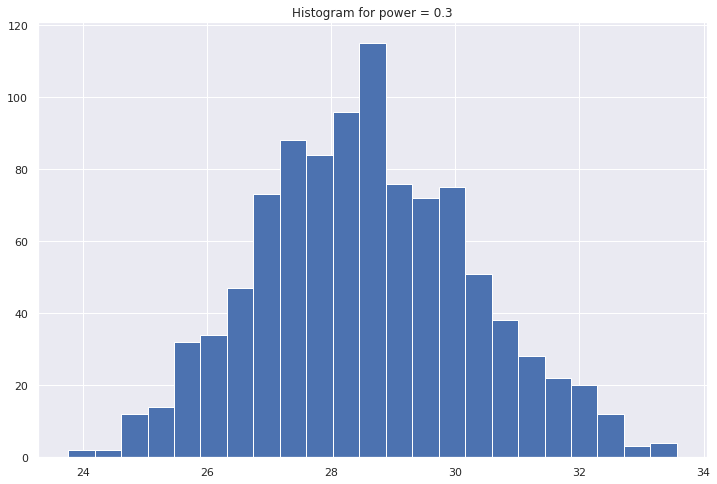

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=80.46774730838166, pvalue=0.0)
odrzucamy hipotezę zerową


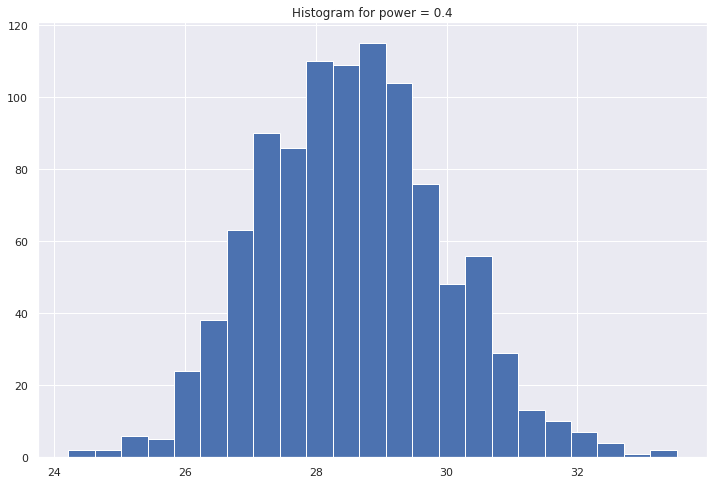

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=89.96296007027284, pvalue=0.0)
odrzucamy hipotezę zerową


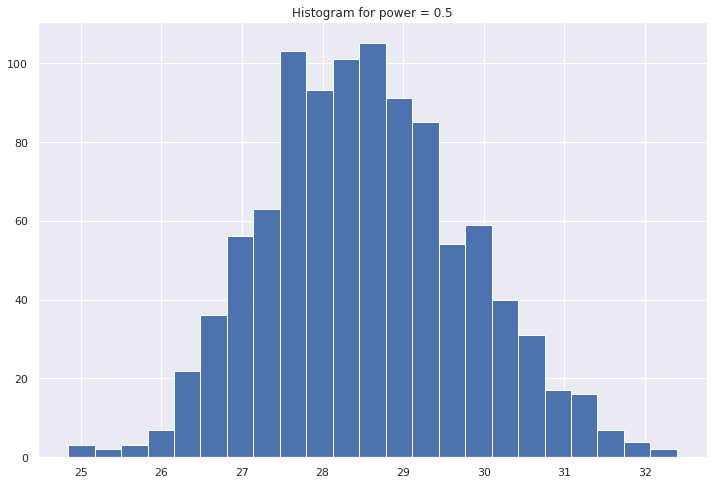

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=100.52763878652163, pvalue=0.0)
odrzucamy hipotezę zerową


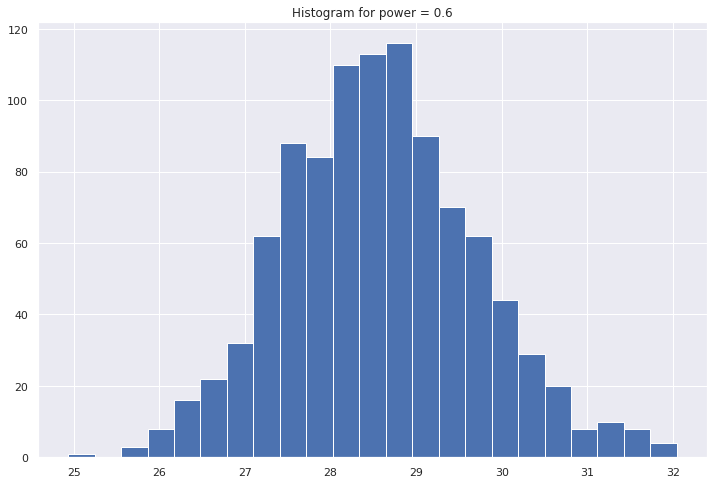

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=114.67012661583036, pvalue=0.0)
odrzucamy hipotezę zerową


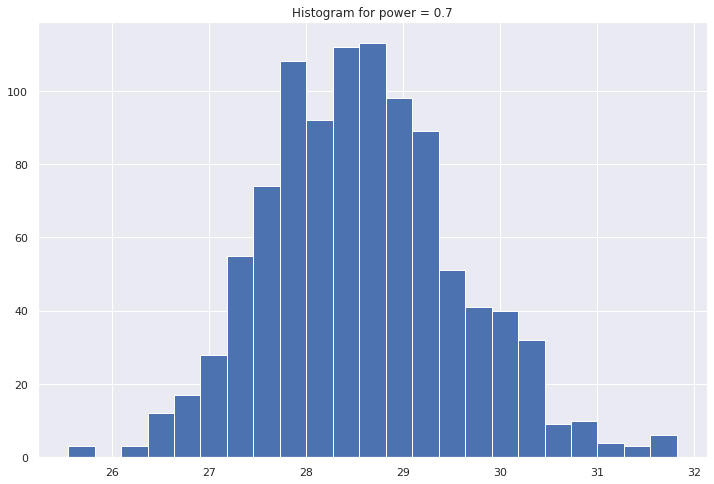

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=126.9930129222816, pvalue=0.0)
odrzucamy hipotezę zerową


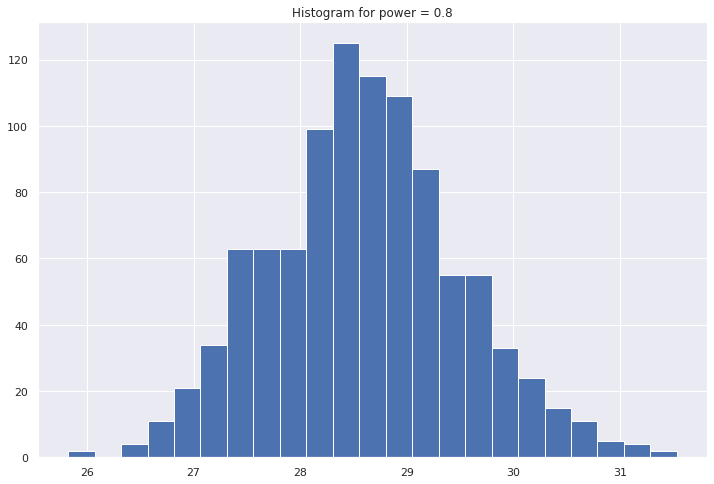

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=150.3463543521514, pvalue=0.0)
odrzucamy hipotezę zerową


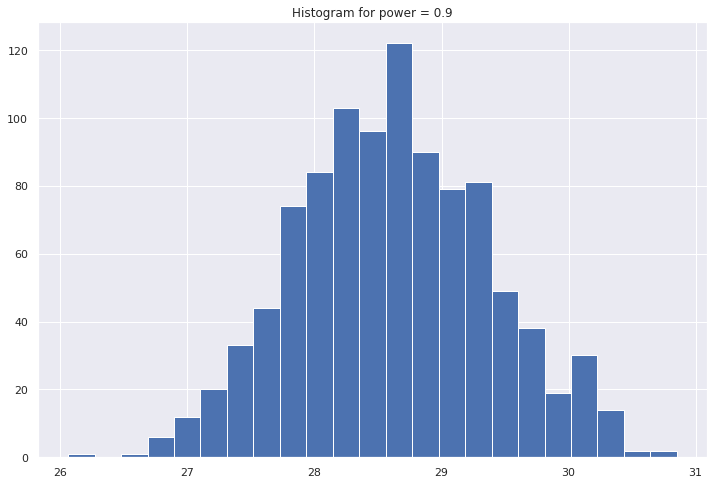

<IPython.core.display.Javascript object>

In [35]:
Interactive_plot_one_sample(body_fat, 25)

### **3.4.** Próba dla zbioru "Wine"

https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009

Zbiór zawierający wina wraz z ich kwasowością w skali pH i Lotną kwasowość

In [36]:
wine_df = pd.read_csv('Wine.csv')
wine_ph = np.array(wine_df['pH'])
wine_va = np.array(wine_df['volatile acidity'])

#### **3.4.1.** Próba dla zbioru "Wine" dla "pH"

Wyjątkowa sytuacja. Dla power <= 0.2 nie da się wykonać obliczeń

In [37]:
def Interactive_plot_one_sample_wine(group1, value):
  tb = widgets.TabBar([str(i) for i in range(1,8)])
  for i in range(0,7):
      with tb.output_to(i):
        power = (i+3) / 10
        group_1_samples, t_value, p_value = one_sample(group1, value, 0.05, power=power)

        print(f'Bootstraped T-test results: (t-statistic={t_value}, pvalue={p_value})')
        predict_hypothesis(0.05, p_value)

        draw_histogram(group_1_samples, f'Histogram for power = {power}')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=113.63496826806629, pvalue=0.0)
odrzucamy hipotezę zerową


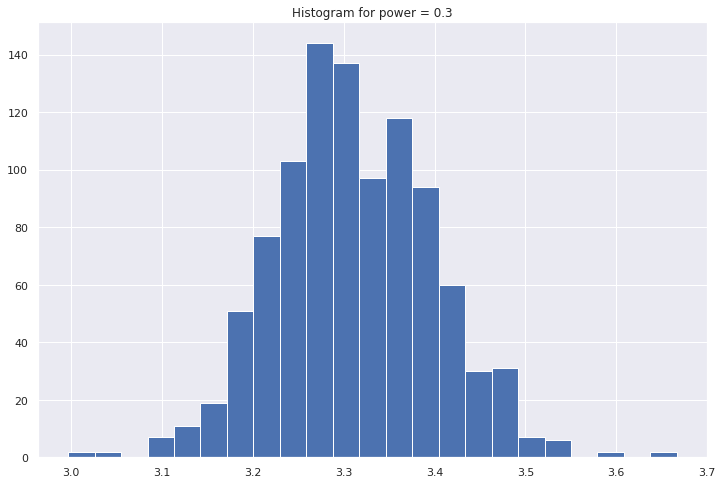

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=113.63496826806629, pvalue=0.0)
odrzucamy hipotezę zerową


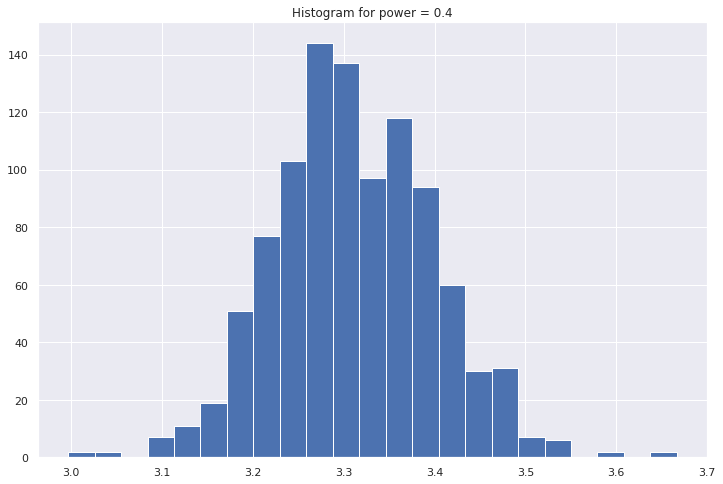

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=126.5737994377335, pvalue=0.0)
odrzucamy hipotezę zerową


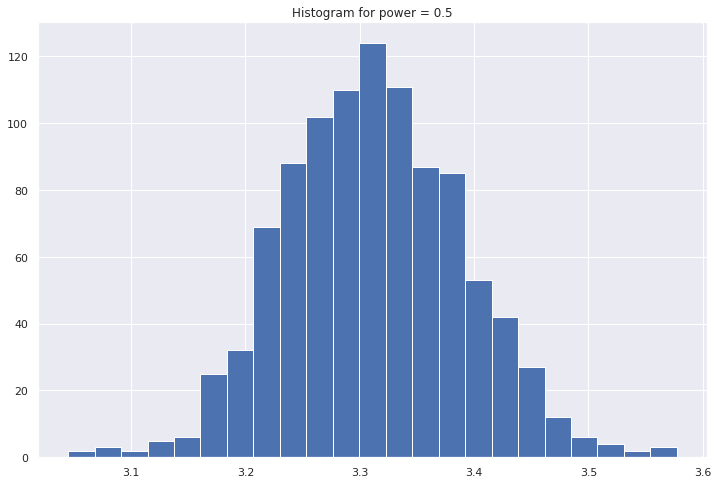

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=126.5737994377335, pvalue=0.0)
odrzucamy hipotezę zerową


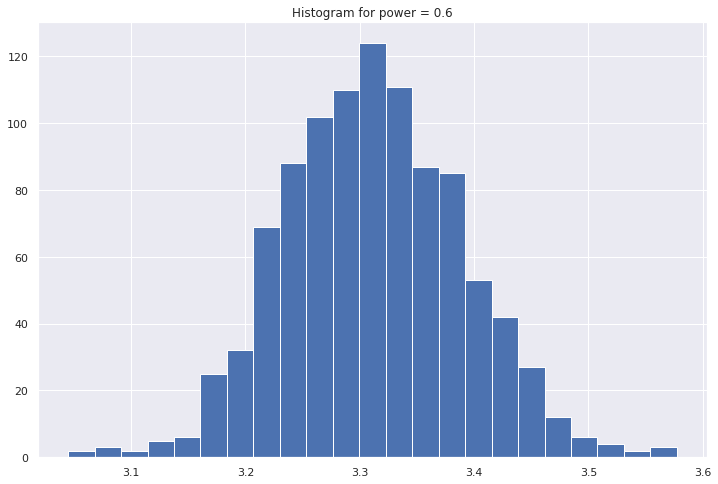

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=139.1769578504404, pvalue=0.0)
odrzucamy hipotezę zerową


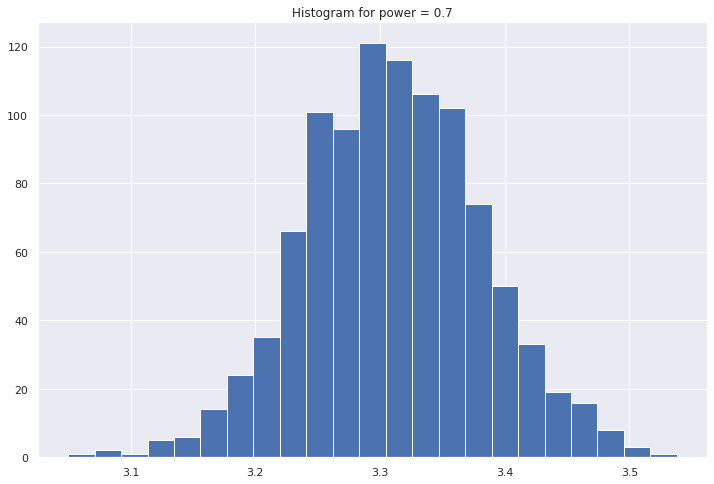

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=156.8428195495753, pvalue=0.0)
odrzucamy hipotezę zerową


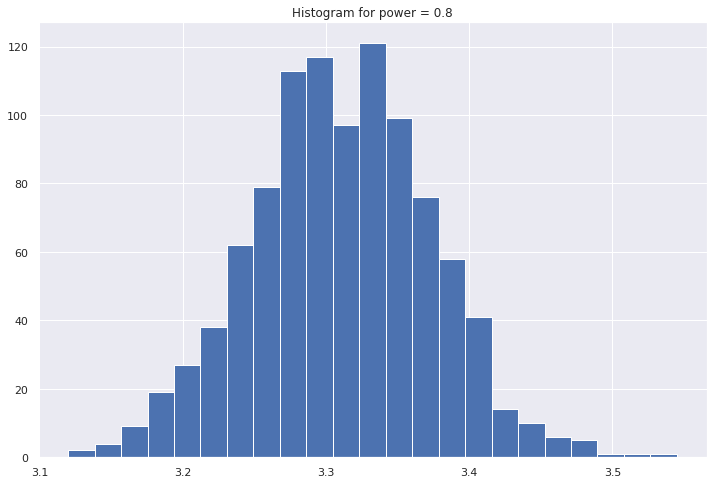

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=165.86303255260884, pvalue=0.0)
odrzucamy hipotezę zerową


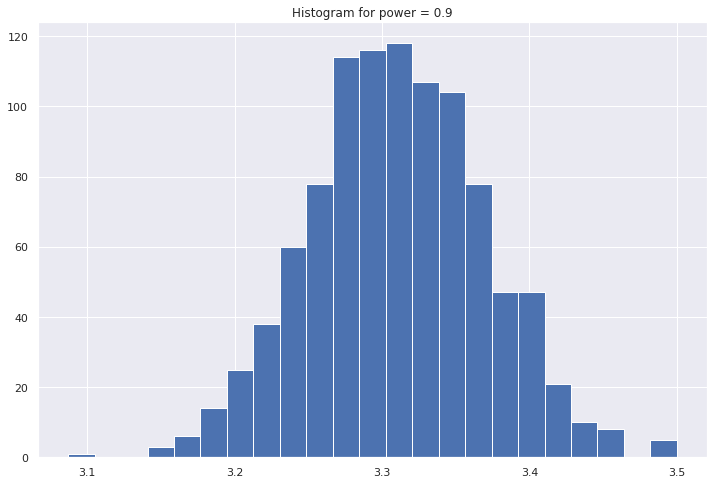

<IPython.core.display.Javascript object>

In [38]:
Interactive_plot_one_sample_wine(wine_ph, 3) ##Dla 3 odrzucamy hipotezę zerową 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-35.58076538657354, pvalue=2.0)
nie ma podstaw do odrzucenia hipotezy zerowej


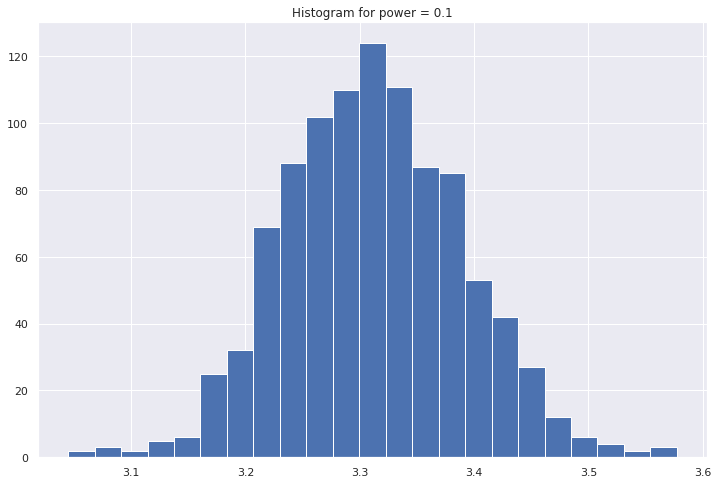

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-56.28116297035732, pvalue=2.0)
nie ma podstaw do odrzucenia hipotezy zerowej


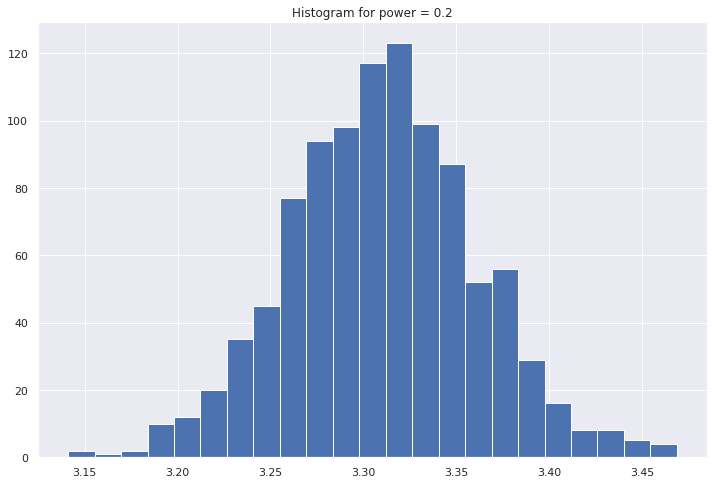

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-69.70790375045902, pvalue=2.0)
nie ma podstaw do odrzucenia hipotezy zerowej


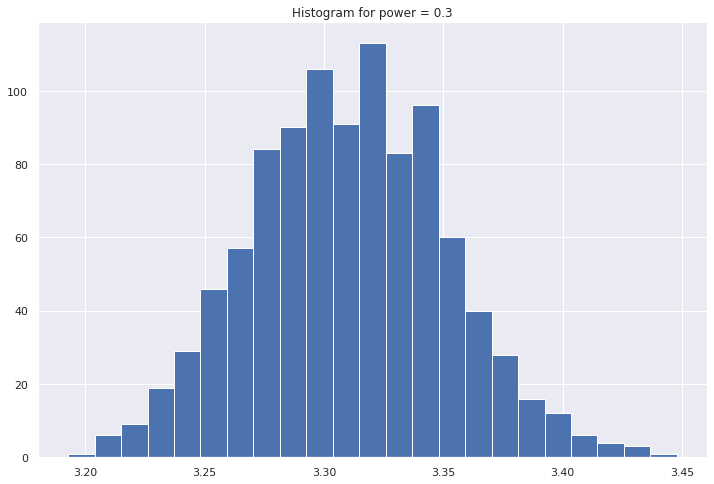

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-81.70422071255362, pvalue=2.0)
nie ma podstaw do odrzucenia hipotezy zerowej


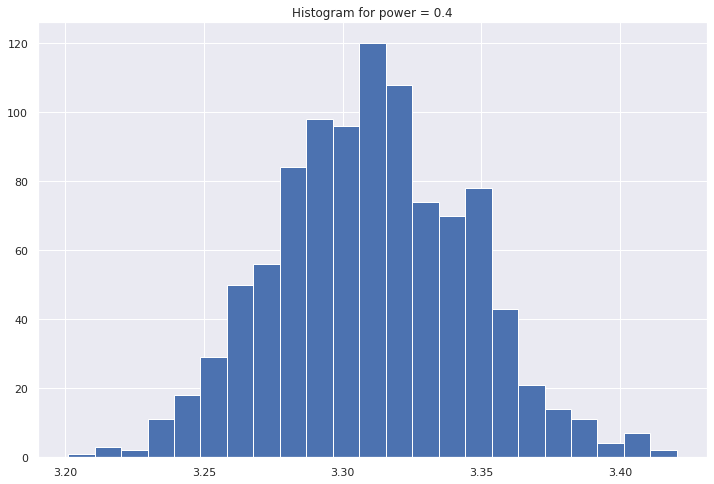

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-92.11150590055449, pvalue=2.0)
nie ma podstaw do odrzucenia hipotezy zerowej


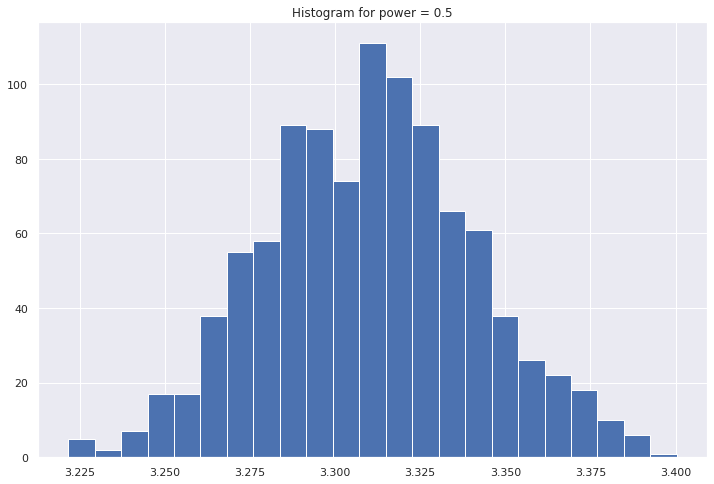

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-101.13006881215296, pvalue=2.0)
nie ma podstaw do odrzucenia hipotezy zerowej


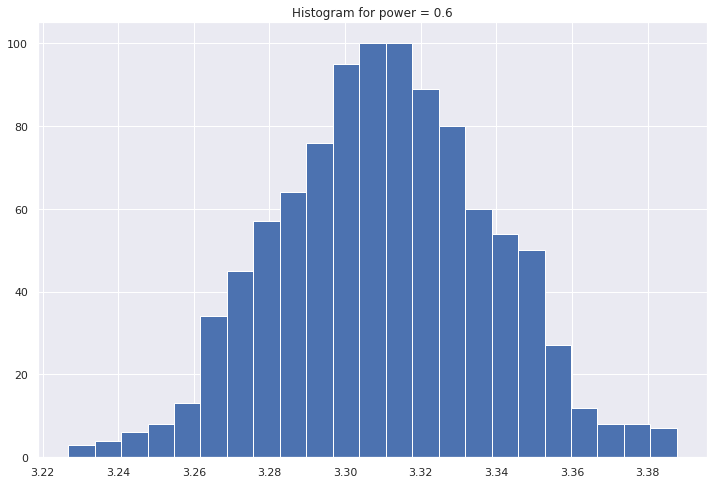

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-110.22502806466714, pvalue=2.0)
nie ma podstaw do odrzucenia hipotezy zerowej


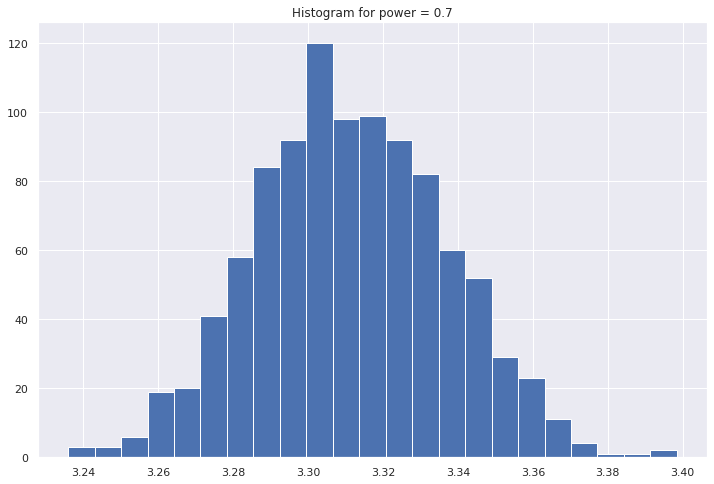

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-123.74516802591538, pvalue=2.0)
nie ma podstaw do odrzucenia hipotezy zerowej


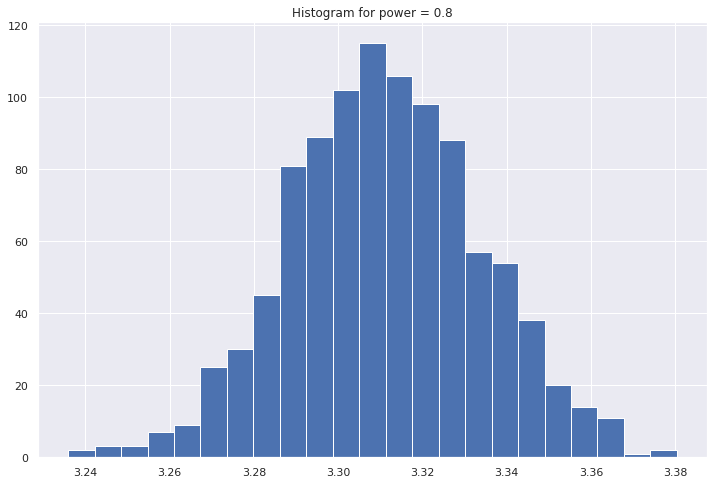

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-151.9872993406393, pvalue=2.0)
nie ma podstaw do odrzucenia hipotezy zerowej


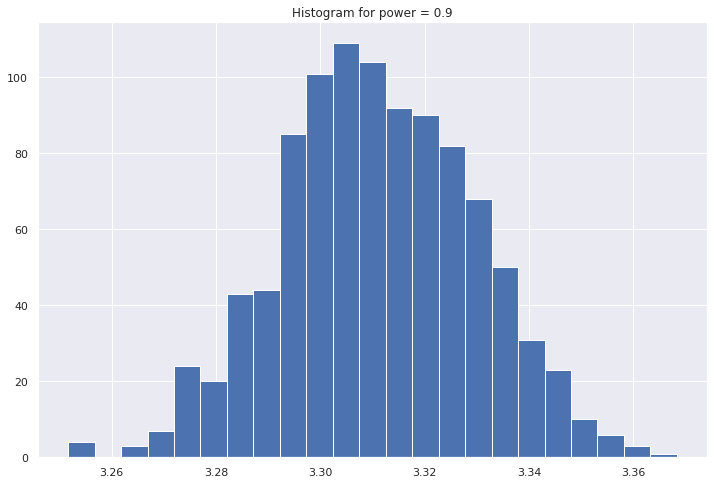

<IPython.core.display.Javascript object>

In [39]:
Interactive_plot_one_sample(wine_ph, 3.4) ##Dla 3.4 nie ma podstaw do odrzucenia hipotezy zerowej

#### **3.4.2.** Próba dla zbioru "Wine" dla "volatile acidity"


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-27.503777869221576, pvalue=2.0)
nie ma podstaw do odrzucenia hipotezy zerowej


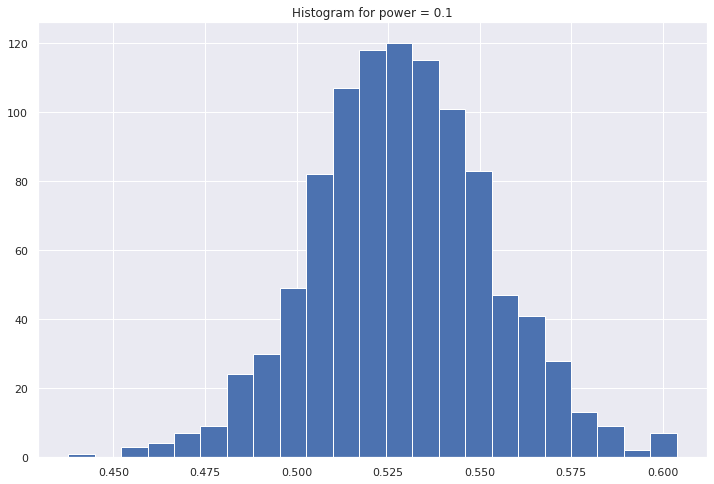

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-49.150348590682306, pvalue=2.0)
nie ma podstaw do odrzucenia hipotezy zerowej


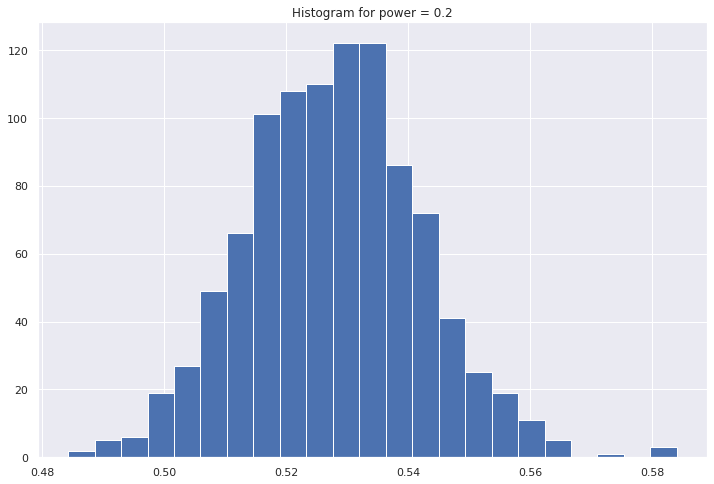

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-64.44085500254897, pvalue=2.0)
nie ma podstaw do odrzucenia hipotezy zerowej


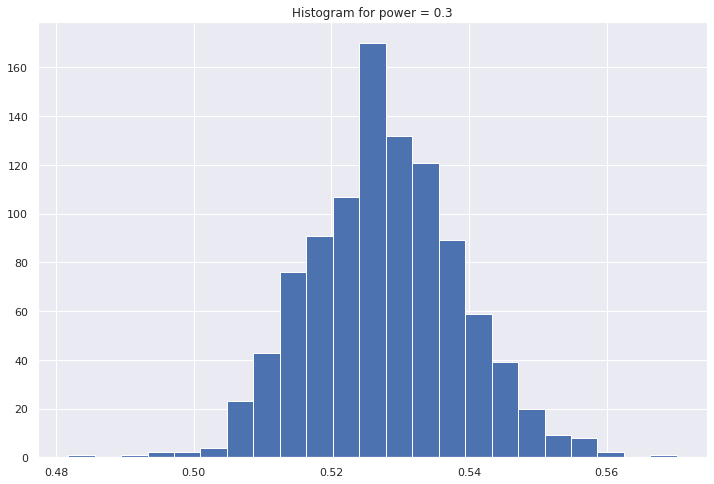

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-77.3194915720877, pvalue=2.0)
nie ma podstaw do odrzucenia hipotezy zerowej


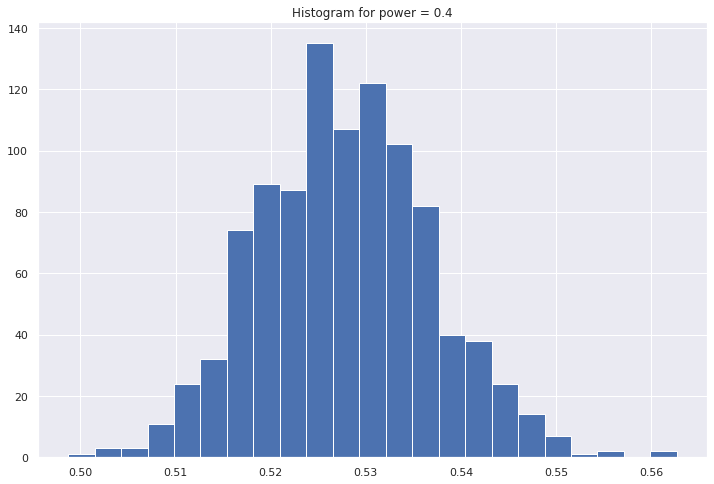

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-86.70013304980435, pvalue=2.0)
nie ma podstaw do odrzucenia hipotezy zerowej


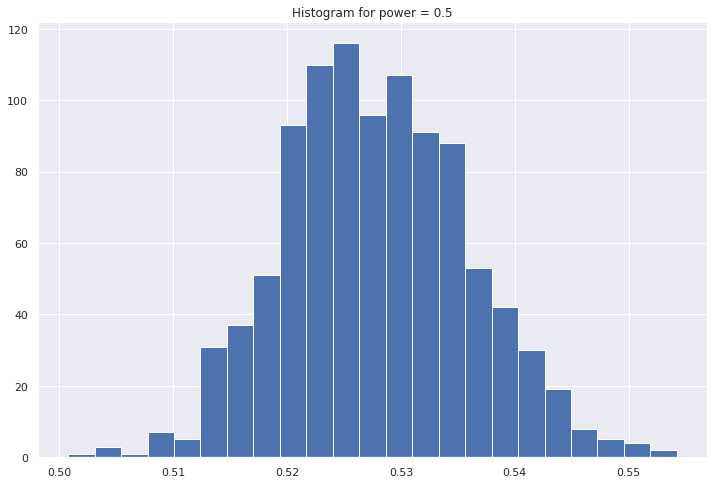

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-95.22256256382494, pvalue=2.0)
nie ma podstaw do odrzucenia hipotezy zerowej


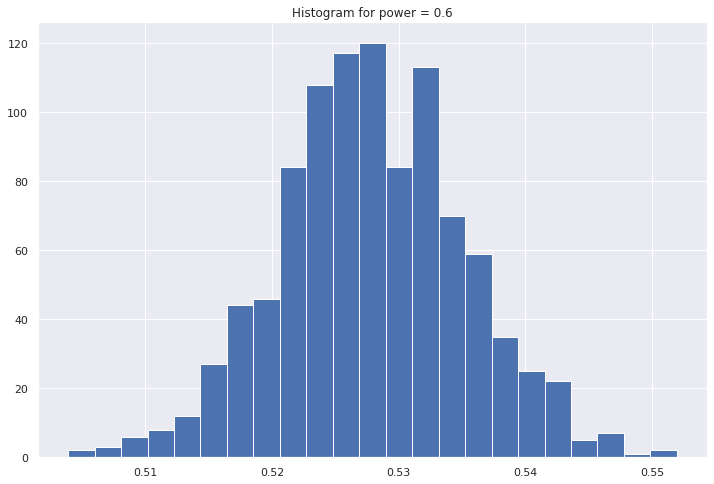

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-109.16771778504153, pvalue=2.0)
nie ma podstaw do odrzucenia hipotezy zerowej


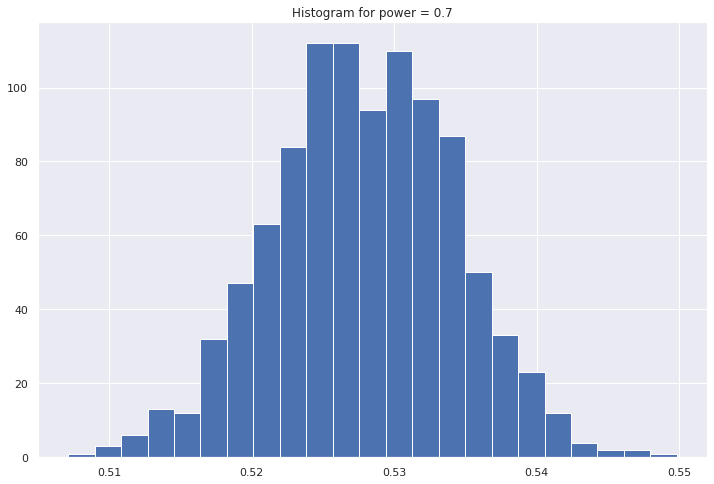

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-123.98023396267806, pvalue=2.0)
nie ma podstaw do odrzucenia hipotezy zerowej


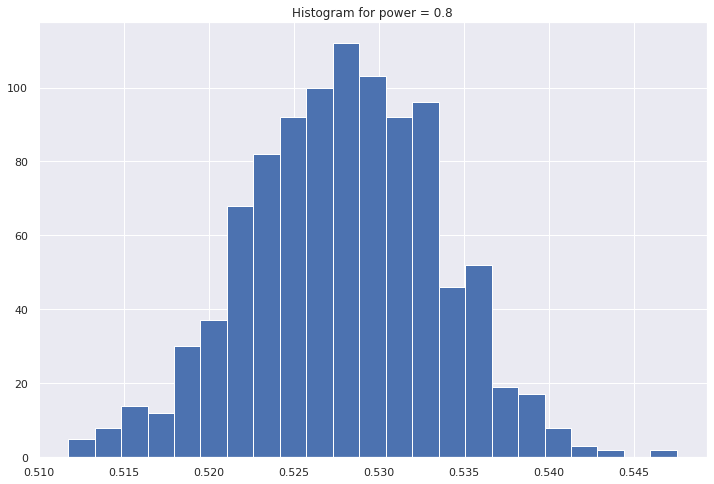

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=-141.022842036901, pvalue=2.0)
nie ma podstaw do odrzucenia hipotezy zerowej


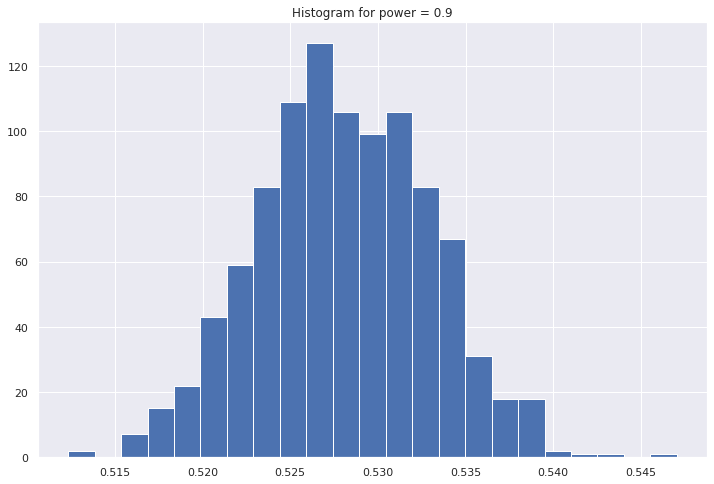

<IPython.core.display.Javascript object>

In [40]:
Interactive_plot_one_sample(wine_va, 0.55) ##Dla 0.55 nie ma podstaw do odrzucenia hipotezy zerowej

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=39.18042324966392, pvalue=3.8294137561856534e-204)
odrzucamy hipotezę zerową


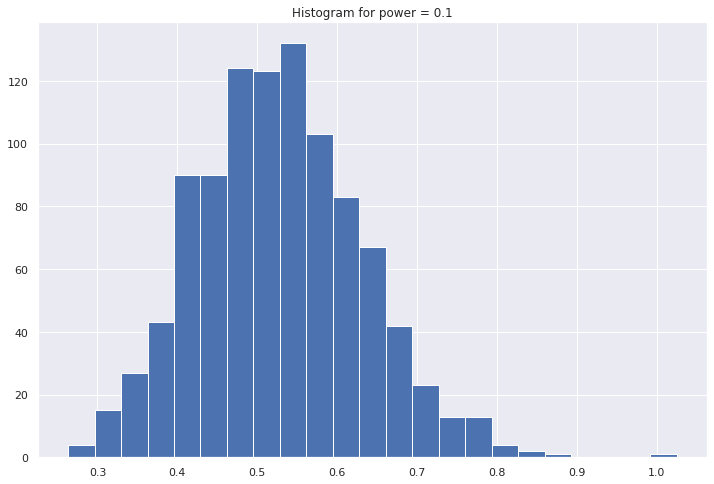

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=55.79508946339778, pvalue=3.318379155873146e-309)
odrzucamy hipotezę zerową


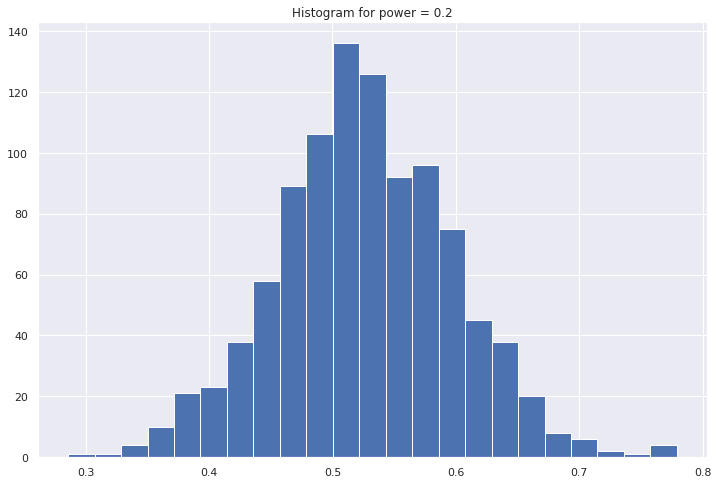

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=70.8427675521255, pvalue=0.0)
odrzucamy hipotezę zerową


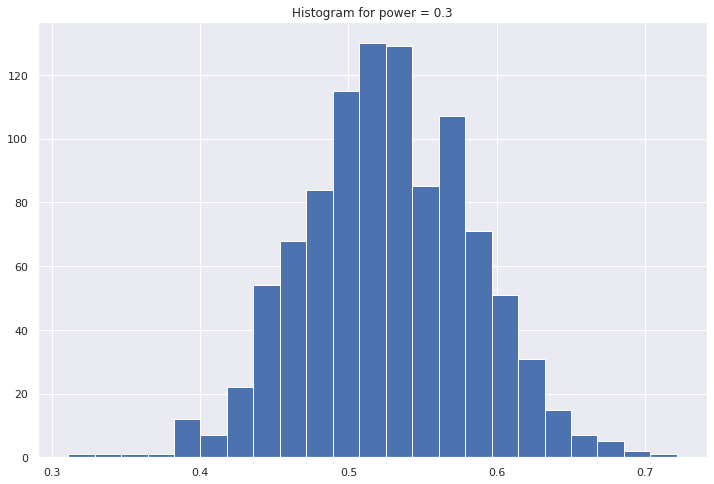

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=80.45813670237419, pvalue=0.0)
odrzucamy hipotezę zerową


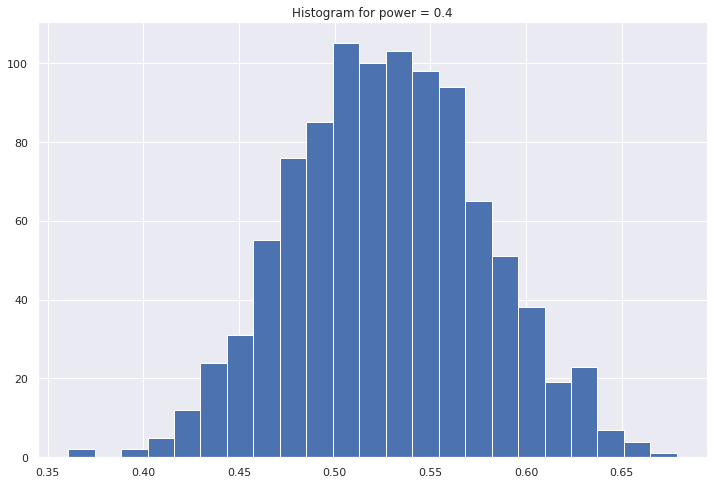

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=91.77266801375961, pvalue=0.0)
odrzucamy hipotezę zerową


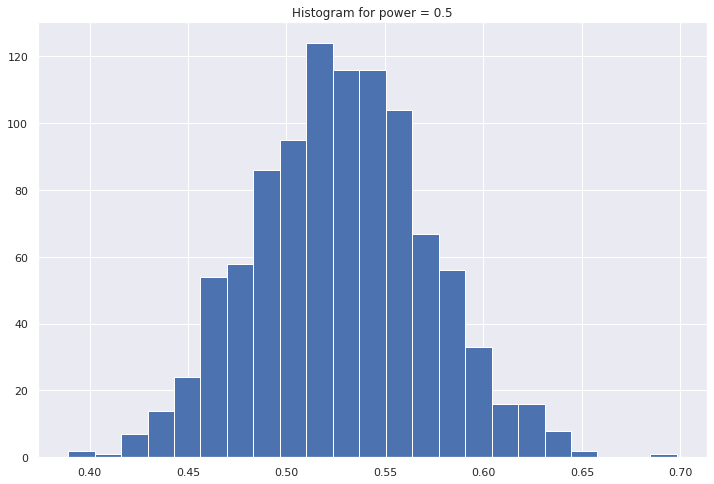

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=102.98511354330476, pvalue=0.0)
odrzucamy hipotezę zerową


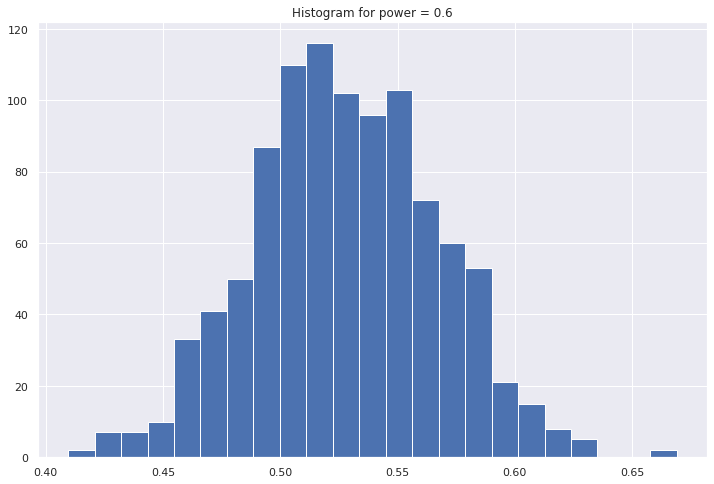

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=114.797990919133, pvalue=0.0)
odrzucamy hipotezę zerową


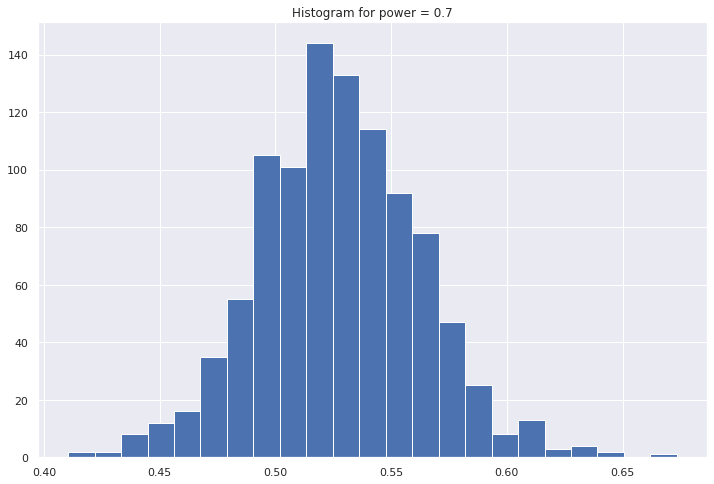

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=123.56908255108068, pvalue=0.0)
odrzucamy hipotezę zerową


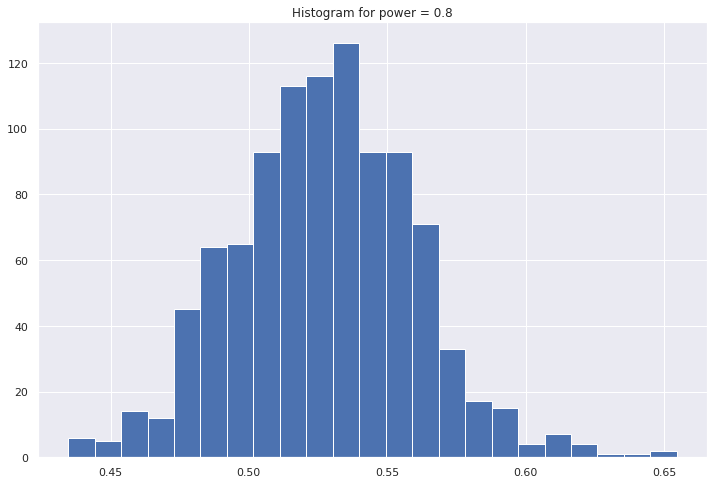

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bootstraped T-test results: (t-statistic=144.12531566321675, pvalue=0.0)
odrzucamy hipotezę zerową


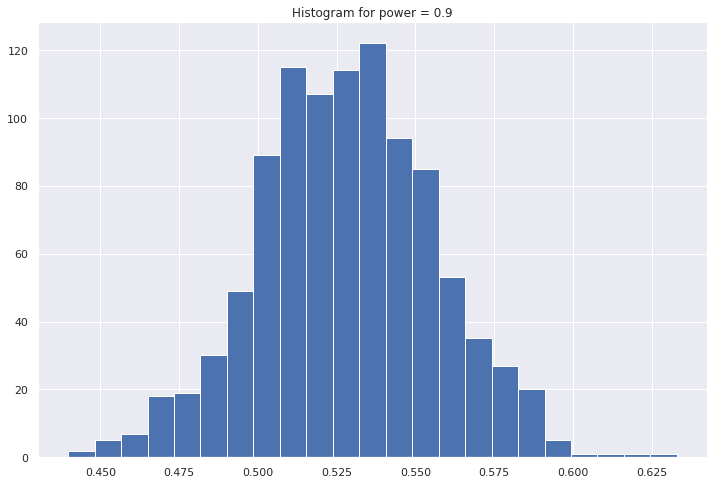

<IPython.core.display.Javascript object>

In [41]:
Interactive_plot_one_sample(wine_va, 0.4) ##Dla 0.4 odrzucamy hipotezę zerową 